<center> <img src = data/img.png alt="drawing" style="width:400px;">

In [16]:
# инструменты анализа и обработки данных
import pandas as pd
import numpy as np
import re
from geopy import distance
from scipy import stats
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_classif

# инструменты для лингвистического анализа:
import string
import spacy
# nltk.download('vader_lexicon')

from nltk import tokenize, stem
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn

# инструменты для визуализации:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# параметры отображения содержимого на экране:
from IPython.display import display
from termcolor import colored
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 40)

# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 0. Исходные данные:

In [17]:
hotels = pd.read_csv('hotels_train.csv')

In [18]:
display(hotels.info())
print(f'\nСтолбцы с явными пропусками данных:\n{hotels.isnull().sum()[hotels.isnull().sum() > 0]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None


Столбцы с явными пропусками данных:
lat    2448
lng    2448
dtype: int64


#### Первоначальная версия датасета содержит 17 полей со следующей информацией:

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве;

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;

lat — географическая широта отеля;

lng — географическая долгота отеля.

### <span style="color:blue">Немного о целевом признаке: ('reviewer_score')</span>
Оценим распределение величины

In [19]:
# проведем тест на нормальность:
alpha = 0.05
_, p = stats.normaltest(hotels['reviewer_score'])

print('Для распределения оценок туристов: p=%.4f' % p)
print('Данные распределены нормально.') if p > alpha/2 else print('Данные не распределены нормально.')

Для распределения оценок туристов: p=0.0000
Данные не распределены нормально.


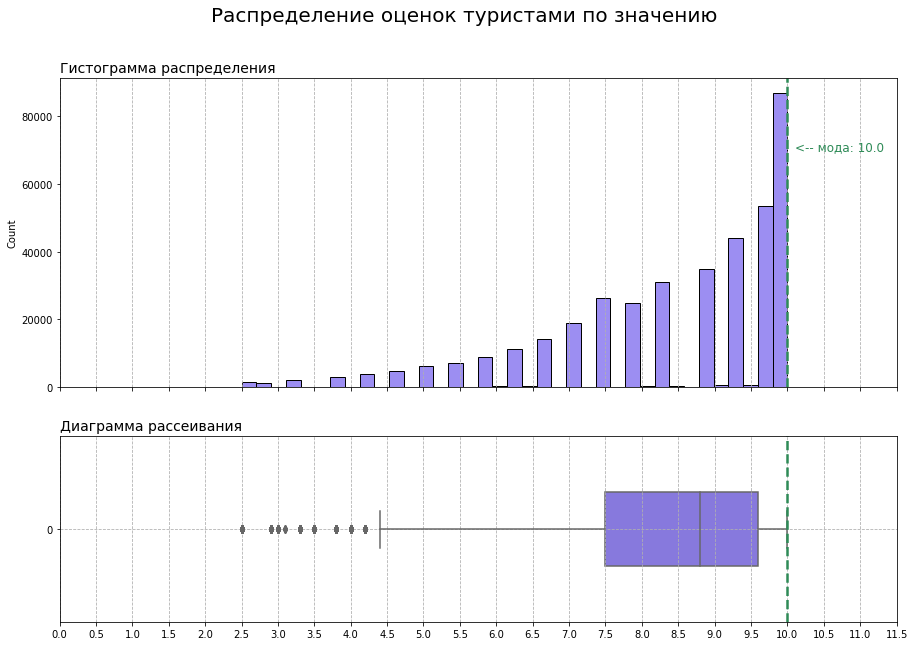

In [20]:
# подготовим данные для диаграмм:
data_score = hotels['reviewer_score']
mode_score = (hotels['reviewer_score'].mode()).max()
colors_score = ['mediumslateblue', 'seagreen']

# формируем размеры диаграмм:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(15, 10), gridspec_kw={'height_ratios': [5, 3]})
plt.suptitle('Распределение оценок туристами по значению', size=20)

# строим гистограмму распределения:
ax[0].set_title('Гистограмма распределения', ha='left', x=.0, fontsize=14)
sns.histplot(ax=ax[0], data=data_score, bins=len(hotels['reviewer_score'].value_counts()), color=colors_score[0]).xaxis.grid(linestyle='--')

# строим коробчатую диаграмму:
ax[1].set_title('Диаграмма рассеивания', ha='left', x=.0, fontsize=14)
sns.boxplot(ax=ax[1], data=data_score, color=colors_score[0], width=0.4, orient='h').grid(linestyle='--')

# для наглядности добавим линию модального значения:
ax[0].axvline(x=mode_score, color=colors_score[1], ls='--', lw=2.5)
ax[0].text(10.1, 70000, f'<-- мода: {mode_score}', fontsize = 12, color=colors_score[1])
ax[1].axvline(x=mode_score, color=colors_score[1], ls='--', lw=2.5)

ax[1].set_xticks(np.arange(0, 12, 0.5))
ax[1].set_xlabel('');

##### И тест однозначно показывает, что данные не распределены нормально. А вот на графике - "все не так однозначно". В уровне количества выставленных оценок - шаг от шага наблюдаются "взлеты и падения" показателей. При поступательном движении по шкале оценок - некоторые оценки более популярны, некоторые - почти не заметны, некоторые - отсутствуют вовсе.
##### Но есть что-то нормальное, в этом - вроде бы ненормальном распределении.
##### Это связано со спецификой расчета и округления средней оценки отзыва на Booking.com на основании оценок по отдельным категориям. Некоторые категории оценки, например 9.8 или 7.2 - не встречаются совсем. Этот средний балл невозможно получить ни при какой комбинации оценок по различным параметрам.

<left> <img src = data/img_score.png alt="Drawing" width=400, height=400>

In [21]:
# это демонстрирует и таблица уникальных значений:
hotels['reviewer_score'].value_counts()

10.000    86803
9.600     53502
9.200     44053
8.800     34795
8.300     30903
7.500     26164
7.900     24901
7.100     18529
6.700     14117
6.300     11244
5.800      8962
5.400      7082
5.000      6278
4.600      4660
4.200      3827
3.800      3017
3.300      2063
2.500      1632
2.900      1211
9.500       523
9.000       483
8.000       388
8.500       379
7.000       293
6.500       274
6.000       184
5.500       161
4.500        97
4.000        66
3.500        61
9.400        47
8.100        28
3.000        25
6.900        23
5.600        13
4.400         9
3.100         6
Name: reviewer_score, dtype: int64

Рецензент оценивает 6 категорий в 4 степенях. Каждая категория - 10 баллов суммарно, за каждый шаг + 2,5 балла к сумме по категории, а итоговая оценка - среднее арифметическое с округлением до десятых.
Если посмотреть на динамику самых популярных оценок - то это те самые 10, 9.6, 9.2 и так далее. Вполне себе нормальное одностороннее (экпоненциальное) распределение.

А вот откуда взялись остальные оценки, с шагом по 0.5 - не очень понятно. Суммарное их количество - меньше процента от общего числа. Может это, например, результаты тестирования альтернативной системы оценивания, или просто поврежденные данные, или еще что-то.
В любом случае, я считаю, что наша зависимая переменная - это нормально распределенная переменная. И к ней применимы все закономерности данного вида распределений.

Строим диаграмму qq-plot


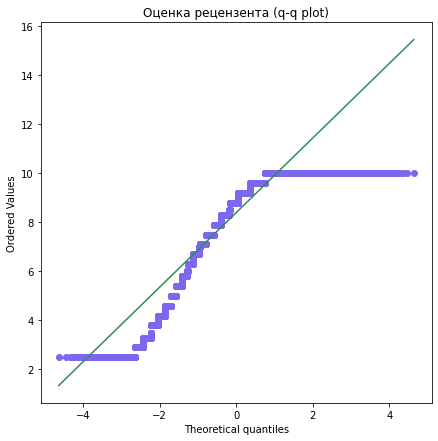

In [22]:
# диаграмма теоретических квартилей:
fig0, ax0 = plt.subplots(figsize=(7, 7))

stats.probplot(hotels['reviewer_score'], plot=ax0)
ax0.set_title('Оценка рецензента (q-q plot)')
ax0.get_lines()[0].set_color('mediumslateblue')
ax0.get_lines()[0].set_markerfacecolor('mediumslateblue')
ax0.get_lines()[1].set_color('seagreen')

plt.show()

##### Вот и я о том же!

# 1. Исследование и проектирование признаков (FEATURE ENGINEERING):

## 1.1 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ ОТЕЛЬ

***Название и Адрес отеля ('hotel_address', 'hotel_name')***

***Координаты отеля - Географическая широта и долгота отеля ('lat', 'lng')***

***Средний балл отеля за последний год ('average_score')***

***Общее количество отзывов об отеле ('total_number_of_reviews')***

***Общее количество оценок без отзывов ('additional_number_of_scoring')***


### <span style="color:blue">НАЗВАНИЕ ОТЕЛЯ ('hotel_name')</span>

In [23]:
# исследуем данные о названии и адресе отеля на наличие пропусков и дубликатов:
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()
name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
addresses_rep = hotels[hotels['hotel_name'].isin(name_rep)][['hotel_name', 'hotel_address']].value_counts()

print(colored('Дублирование Названия отеля:', 'green'))
display(addresses_rep)

# чтобы различать эти отели при анализе - добавим в название город отеля:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print(colored('\nПроверим полученные изменения:', 'green'))
display(hotels[hotels['hotel_name'].str.contains(name_rep[0])]['hotel_name'].value_counts())

Дублирование Названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    440
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           222
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     47
dtype: int64


Проверим полученные изменения:


Hotel Regina Barcelona    440
Hotel Regina Vienna       222
Hotel Regina Milan         47
Name: hotel_name, dtype: int64

***Название отеля можно использовать для обучения модели, только если его кодировать. Код названия сам по себе вряд ли может что-то сообщить. Отелей около полутора тысячи и числовой код скорее запутает модель из-за своей размерности, не несущей никакой смысловой нагрузки.***

Попробуем сообщить модели хоть какую-то осмысленную информацию. Название - это уникальная характеристика отеля. Отели можно отсортировать, например, по популярности (кол-во отзывов) или по рейтингу (средний бал). Но тогда получится, что наш признак будет дублировать по смыслу или столбец с количеством отзывов, или столбец со средней оценкой.

Закодируем название, используя обе эти характеристики. Пусть у нас будут только лучшие по отзывам и достаточно популярные отели.

In [24]:
# выделим топ лучших по рейтингу отелей, имеющих порог в 100 отзывов:
hotels_names = hotels.groupby('hotel_name')['average_score'].agg(['mean', 'count'])
hotels_top = hotels_names[(hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)]

print(colored('\nЛучшие по отзывам отели, имеющие минимум 100 отзывов:', 'green'))
display(hotels_top)

# определяем категории отелей:
hotels['hotel_cat'] = hotels['hotel_name'].apply(lambda n: n if n in hotels_top.index else 'other')

# применим порядковое кодирование:
ord_encoder = OrdinalEncoder()
hotels['hotel_cat'] = hotels['hotel_cat'].astype('category')
hotels_bin = ord_encoder.fit_transform(hotels['hotel_cat'])
hotels = pd.concat([hotels, hotels_bin], axis=1)

# удалим ненужные вспомогательные столбцы:
col = hotels.columns.tolist()
col[18] = 'hotel_code'

hotels.set_axis(col, axis=1, inplace=True)
hotels.drop('hotel_cat', axis=1, inplace=True);


Лучшие по отзывам отели, имеющие минимум 100 отзывов:


,mean,count
hotel_name,,
Acad mie H tel Saint Germain,9.000,192
Alma Barcelona GL,9.200,136
Amba Hotel Charing Cross,9.300,581
Ambassade Hotel,9.300,437
Andaz Amsterdam Prinsengracht A Hyatt Hotel,9.300,157
...,...,...
Waldorf Astoria Amsterdam,9.500,108
art otel Amsterdam,9.000,603
citizenM London Bankside,9.100,1135


### <span style="color:blue">АДРЕС ОТЕЛЯ ('hotel_address')</span>

In [25]:
addresses = pd.Series(hotels['hotel_address'].unique())

print(colored('\nРассмотрим внимательно структуру строк с данными адреса:', 'green'))
display(addresses)


Рассмотрим внимательно структуру строк с данными адреса:


0       Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
1                   130 134 Southampton Row Camden London WC1B 5AF United Kingdom
2                                151 bis Rue de Rennes 6th arr 75006 Paris France
3                              216 Avenue Jean Jaures 19th arr 75019 Paris France
4                                       Molenwerf 1 1014 AG Amsterdam Netherlands
                                          ...                                    
1488                              Viriotgasse 5 09 Alsergrund 1090 Vienna Austria
1489                                     8 rue d Anjou 8th arr 75008 Paris France
1490        Prinsengracht 717 Amsterdam City Center 1017 JW Amsterdam Netherlands
1491                          43 Rue De l Abb Gr goire 6th arr 75006 Paris France
1492                      Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria
Length: 1493, dtype: object

***Из адреса можно извлечь гораздо больше полезной информации, чем из названия. Страна, город и индекс как характеристика района могут стать дополнительными признаками!***

In [26]:
# для вычленения гео-параметров можно было бы воспользоваться locationtagger, но он работает довольно медленно и с ошибками
# поскольку у нас не большое количество уникальных стран и городов в данных - воспользуемся простой обработкой текста:
countries = addresses.apply(lambda x: x.split()[-1])
countries = countries.apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

cities = addresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x == 'United' else x)

addresses = pd.DataFrame({'address': addresses, 'country': countries, 'city': cities})

print(colored('\nВ каждой стране отели представлены только из одного города:', 'green'))
display(addresses.groupby(['country', 'city']).count())

# можно добавить в данные что-то одно - я выберу страну (так потом будет удобно сопоставить ее национальностью рецензента)
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

# кодируем информацию о стране:
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes


В каждой стране отели представлены только из одного города:


,,address
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


Идентифицировать район города можно по индексу в строке адреса отеля. Район города способен сильно повлиять на впечатление туриста об отеле. Среди прочих параметров многие туристы, оставляющие отзыв на Booking.com часто оценивают месторасположение отеля.

In [27]:
# добавим почтовый индекс отеля как идентификатор района:
def get_postcode(address):
    address_list = address.split()
    postcode_place = {'Kingdom': -4, 'Spain': -3, 'France': -3, 'Austria': -3, 'Netherlands': -4, 'Italy': -3}
    postcode = str(address_list[postcode_place[address_list[-1]]])
    return postcode[:-1] if (address_list[-1] == 'Kingdom' and postcode[-1].isalpha()) else postcode

hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

# из файла с данными об расположении центральных районов данных городов - определим категорию района:
districts = pd.read_excel('data/regions.xlsx', sheet_name='postcodes')
districts['PostCode'] = districts['PostCode'].apply(lambda x: str(x))
districts = districts.set_index('PostCode')
districts = districts.to_dict()
districts = districts['Type of District']

hotels['district_type'] = hotels['hotel_postcode'].apply(lambda x: districts[x])

# кодируем типы района (причем стараемся, чтобы величина кода укладывалась в какую-то логику)
# например, меньшие числа - соответствуют центральным категориям:
def get_district_code(district_type, country_code):
    if district_type == 'History Center':
        return country_code
    elif district_type == 'Center':
        return country_code  + 6
    elif district_type == 'Other':
        return country_code + 12
    else:
        return country_code + 18

hotels['district_code'] = hotels.apply(lambda row: get_district_code(row['district_type'], row['hotel_country_code']), axis=1)

# присвоим каждому району категорию в зависимости от популярности отелей в данной местности у туристов
pivot_adr = pd.pivot_table(hotels, index='hotel_postcode', values='average_score', aggfunc='mean')
pivot_adr = pivot_adr.reindex(pivot_adr['average_score'].sort_values(ascending=False).index)

# для этого нормализуем информацию о среднем рейтинге отеля в зависимости от индекса
# хотя, как показали мои эксперименты, размерность признака не особо влияет на модель:
mm_scaler = MinMaxScaler()
x_data = pivot_adr.values
x_scaled = mm_scaler.fit_transform(x_data)
pivot_adr['district_rating'] = x_scaled

hotels['district_rating'] = hotels['hotel_postcode'].apply(lambda x: pivot_adr['district_rating'][x])

hotels[['hotel_address', 'hotel_postcode', 'district_rating', 'district_type', 'hotel_country_code', 'district_code']][:10]

,hotel_address,hotel_postcode,district_rating,district_type,hotel_country_code,district_code
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,W1,0.546,Center,5,11
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,WC1,0.494,Center,5,11
2,151 bis Rue de Rennes 6th arr 75006 Paris France,75006,0.748,Center,1,7
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,75019,0.255,Other,1,13
4,Molenwerf 1 1014 AG Amsterdam Netherlands,1014,0.647,Center,3,9
5,Via Mecenate 121 20138 Milan Italy,20138,0.434,Other,2,14
6,97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom,SW7,0.495,Other,5,17
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,1080,0.643,Center,0,6
8,190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom,SW7,0.495,Other,5,17
9,Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom,W11,0.374,Other,5,17


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в зависимости от типа района в каждом городе:</span>

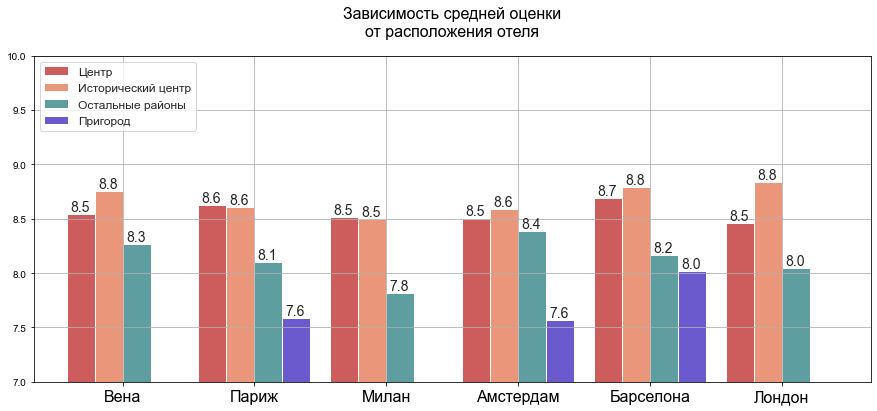

In [28]:
pivot_district_type = (hotels.groupby(['hotel_country', 'district_type'])['reviewer_score'].mean().unstack())

fig1, ax1 = plt.subplots(figsize=(15, 6))
sns.set_style('whitegrid')
district_type_plot = pivot_district_type.plot(
    ax=ax1, kind='bar', width=0.85, color=['indianred', 'darksalmon', 'cadetblue', 'slateblue'],
    label=['Вена', 'Париж', 'Милан', 'Амстердам', 'Барселона', 'Лондон'], rot=0)

ax1.set_title('Зависимость средней оценки\nот расположения отеля', pad = 20, size=16)
ax1.set_xlabel('')
ax1.set_xticklabels(['Вена', 'Париж', 'Милан', 'Амстердам', 'Барселона', 'Лондон'], fontsize=16)
ax1.legend(['Центр', 'Исторический центр', 'Остальные районы', 'Пригород'], loc='upper left', fontsize=12)

# для наглядности добавим на диаграмму подписи данных:
for p in district_type_plot.patches:
    district_type_plot.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(7, 10);

### <span style="color:blue">ГЕОГРАФИЧЕСКИЕ КООРДИНАТЫ ОТЕЛЯ ('lat', 'lng')</span>

Вообще координаты сами по себе мало что могут сообщить модели, но можно попробовать извлечь из них какую-то полезную информацию. Например расстояние до центра города. Из информации о датасете мы помним, что именно в этих столбцах есть пропуски. Сначала удалим пропуски, затем добавим новый признак.

In [29]:
count_hotels_without_coor = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts())
print(f'Количество отелей с отсутствующими координатами: {count_hotels_without_coor}')

# вычисляем средние значения координат для каждого района:
pivot_coor = pd.pivot_table(hotels, index='hotel_postcode', values=['lat', 'lng'], dropna=True, aggfunc='mean')

# заполняем отсутствующие координаты:
hotels['lat'] = hotels.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] if np.isnan(row['lng']) else row['lng'], axis=1)

Количество отелей с отсутствующими координатами: 17


In [30]:
# для формирования нового признака нужны координаты центра каждого города (с сайта: https://dateandtime.info/):
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')


def get_to_center_distance(country, lng, lat):
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return distance.geodesic([center_lng, center_lat], [lng, lat]).km

# можно одной строкой кода вычислять координаты для в DataFrame, но geopy.distance.geodesic функция довольно медленная
# hotels['hotel_distance_to_center'] = hotels.apply(lambda row: get_to_center_distance(row['hotel_country'], row['lng'], row['lat']), axis=1)

# чтобы не обрабатывать 500 тыс. строк посчитаем эту характеристику для каждого отеля и потом сопоставить полученные результаты:
hotels_unique = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()

hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_to_center_distance(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)
hotels = hotels.merge(hotels_unique, how='left', on='hotel_name', sort=False)

print(colored('\nПроверим новый признак:', 'green'))
hotels[['hotel_name', 'hotel_distance_to_center']][:15]


Проверим новый признак:


,hotel_name,hotel_distance_to_center
0,The May Fair Hotel,1.984
1,Mercure London Bloomsbury Hotel,1.420
2,Legend Saint Germain by Elegancia,2.712
3,Mercure Paris 19 Philharmonie La Villette,6.402
4,Golden Tulip Amsterdam West,4.886
5,Novotel Milano Linate Aeroporto,7.676
6,Holiday Inn London Kensington Forum,6.755
7,Mercure Josefshof Wien,1.982
8,The Gore Hotel Starhotels Collezione,6.020
9,Hilton London Kensington Hotel,9.686


***Я удаляю координаты, так как эти разно-мерные числа не несут никакой смысловой нагрузки для модели.***

In [31]:
hotels.drop(['lng', 'lat'], axis=1, inplace=True)

### <span style="color:blue">СРЕДНИЙ БАЛЛ ОТЕЛЯ ('average_score')</span>

Кажется, что это один из самых самодостаточных признаков. Это количественный параметр отеля, в той же размерности и формате, что и целевая переменная. Никаких преобразований с ним выполнять не нужно, а его влияние на показатели целевой переменной оценим в следующем блоке - анализе признаков.

### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ ОБ ОТЕЛЕ ('total_number_of_reviews')</span>
### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОЦЕНОК БЕЗ ОТЗЫВА ('additional_number_of_scoring')</span>

Общее кол-во отзывов - показатель говорит о популярности и/или размере отеля. Но, по моему субъективному ощущению, не сильно влияет на оценку туриста. Он, вместе со вторым показателем, скорее говорит о репрезентативности среднего балла отеля. Думаю эти признаки не значимы, оставим вопрос об их удалении до этапа отбора признаков.

*P.S. Тут я ошиблась. После построения итоговой модели признак общего количества отзывов попал топ-15 самых важных. Действительно, отели, которые имеют мало отзывов - обычно это новые отели с высокими оценками, которые очень заботятся о своем рейтинге на сайте и проявляют к постояльцам больше внимания.*

## 1.2 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ РЕЦЕНЗЕНТА И ОПЫТ ПРЕБЫВАНИЯ В ОТЕЛЕ

***Страна рецензента ('reviewer_nationality')***

***Теги, которые рецензент дал отелю ('tags')***

***Количество отзывов, которые рецензенты дали в прошлом ('total_number_of_reviews_reviewer_has_given')***

### <span style="color:blue">СТРАНА РЕЦЕНЗЕНТА ('reviewer_nationality')</span>

In [32]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
print(f'Представители {len(hotels["reviewer_nationality"].value_counts())} стран являются рецензентами.')

Представители 225 стран являются рецензентами.


На самом деле, я думаю, что не столько страна, сколько социокультурные особенности представителей определенных регионов, действительно могут сказываться на оценках отелей.

Например, туристы из англо-говорящих стран, почти никогда не сталкиваются с языковым барьером в Европейских отелях. А это немаловажный фактор при заселении, выяснении дополнительной информации и решении возникающих проблем. Отсюда следует, что скорее всего такие туристы будут в большей степени довольны пребыванием в отеле, чем остальные.

А вот туристы из ближневосточных стран - могут столкнуться в европейских отелях с большим количеством бытовых сложностей, так как их образ жизни сильнее остальных отличается от европейского.

Добавим дополнительные признаки:

In [33]:
# проанализируем например 40 самых распространенных стран, из которых приезжают туристы и выделим общие группы:
print(colored('\nСамые популярные страны:', 'green'))
print(list(hotels['reviewer_nationality'].value_counts(ascending=False)[:40].index))

# выделим основные англоязычные страны:
english_list = ['United Kingdom', 'United States of America', 'Australia', 'Canada', 'New Zealand']
hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x in english_list else 0)

# выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 'Saudi Arabia', 'Turkey', 'Kuwait', 'Qatar', 'Oman']
hotels['reviewer_n_est'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x in muslim_list else 0)

# добавим признак резидентства туриста по отношению к стране, в которой находится отель:
hotels['reviewer_resident'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

# кодируем информацию о стране рецензента:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
hotels['reviewer_nationality_cat'] = hotels['reviewer_nationality'].cat.codes


Самые популярные страны:
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Canada', 'Germany', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'China', 'Sweden', 'India', 'Greece', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal', 'Finland']


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в разрезе полученных признаков:</span>

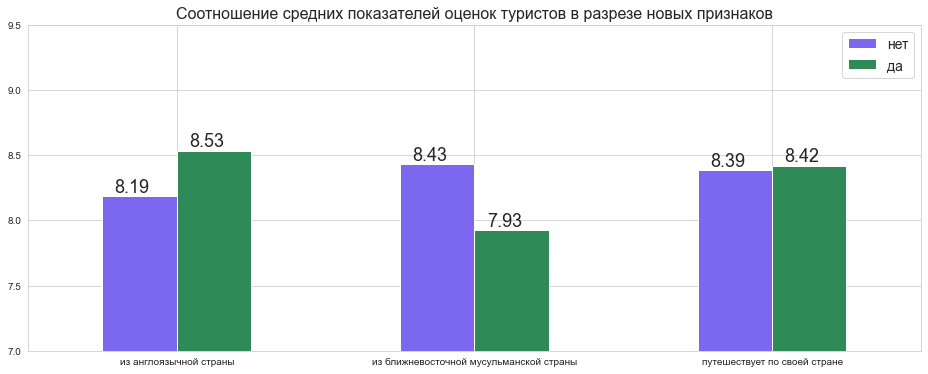

In [34]:
# подготовим данные для диаграммы:
pivot = pd.DataFrame({'из англоязычной страны': hotels.groupby('reviewer_en')['reviewer_score'].mean(),
                      'из ближневосточной мусульманской страны': hotels.groupby('reviewer_n_est')['reviewer_score'].mean(),
                      'путешествует по своей стране': hotels.groupby('reviewer_resident')['reviewer_score'].mean()}).T

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(ax=ax2, kind='bar', color=['mediumslateblue', 'seagreen'], rot=0)
ax2.set_title('Соотношение средних показателей оценок туристов в разрезе новых признаков', size=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)

# для наглядности добавим на диаграмму подписи данных:
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=18)

plt.ylim(7, 9.5);

### <span style="color:blue">ТЭГИ('tags')</span>

***Визуализируем самые популярные теги набора данных:***

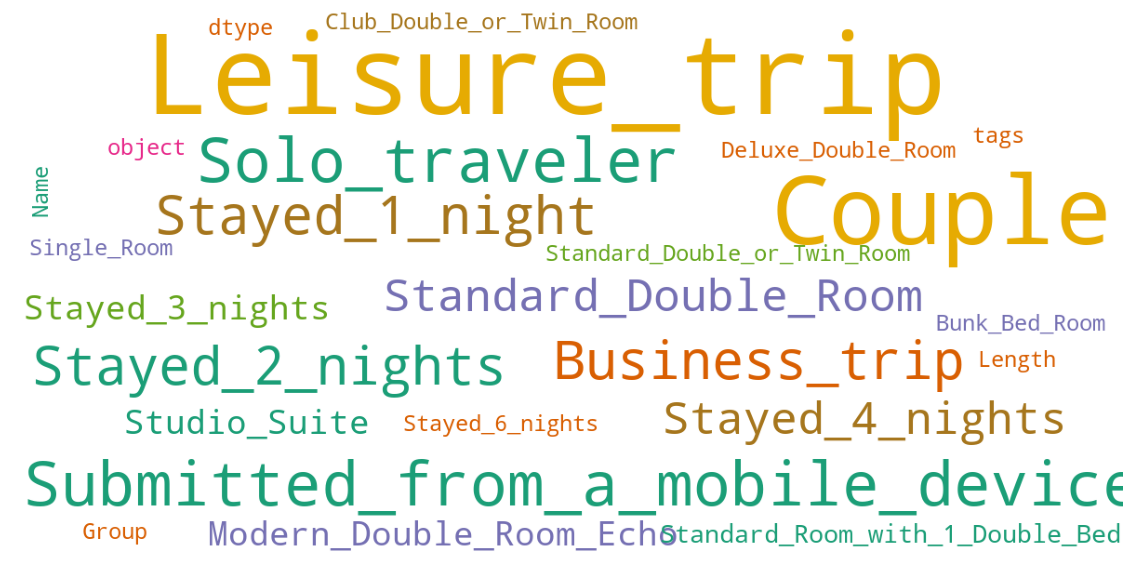

In [35]:
def get_tags_string(tags_data):
    tags_data = tags_data.replace('[', '').replace(']', '').replace("'", '')
    tags_list = tags_data.split(',')

    tags_string = ''
    for teg in tags_list:
        teg = teg.strip().replace(' ', '_')
        tags_string = tags_string + teg + ' '

    return tags_string

# сохраним алгоритм в функцию, воспользуемся им при визуализации наборов слов в отзывах:
def show_wordcloud(data, background_color, colormap):
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 40,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()


cloud = hotels['tags'].apply(get_tags_string)
show_wordcloud(cloud, 'white', 'Dark2')

In [36]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))
print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}')

# проанализируем типы тегов:
hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].head()

Максимальное количество тегов в 1 строке данных: 6


698              [' With a pet ', ' Leisure trip ', ' Solo traveler ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
1276                       [' With a pet ', ' Leisure trip ', ' Group ', ' Superior Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
1407         [' With a pet ', ' Leisure trip ', ' Family with young children ', ' Family Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
2102    [' With a pet ', ' Business trip ', ' Couple ', ' King Room with City View Top floors ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
2281                                  [' With a pet ', ' Leisure trip ', ' Group ', ' 2 rooms ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
Name: tags, dtype: object

***В строке с тэгами содержится много важной и интересной информации.***

Можно выделить 6 типов тегов:
- путешествие с домашними животными
- путешествие по работе / отдых
- путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа)
- категория номера
- длительность поездки
- доступ осуществляется с мобильного устройства

Рассмотрим внимательно категории номеров. Возможно получится выделить их в группы. Кажется, что отзывы о пребывании туристов, которые останавливаются в большом клубном номере с видом и маленьком экономе могут сильно отличаться.

Из типа номера дополнительно выделим признак - номер с видом (думаю, что средний балл отзывов гостей таких номеров должен быть выше обычных).


In [37]:
# создаем новые признаки:
def get_tags(tags_string):
    tags_string = tags_string.replace('[', '').replace(']', '').replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 #  по умолчанию не считаем поездку командировкой
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''

    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)

        if teg == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(teg)

        if teg == 'Leisure trip':
            tags_list.remove(teg)

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', teg)][0]
            tags_list.remove(teg)

    if len(tags_list) > 0:
        tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, tag_reviewer_type, tag_count_nights, tag_room_type


hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).tolist(), index=hotels.index)

print(colored('\nКоличество уникальных значений в новых признаках:', 'green'))
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()


Количество уникальных значений в новых признаках:


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       31
tag_room_type        2329
dtype: int64

In [38]:
# добавим признак номера с видом:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)

# сформируем список основных категорий отельных номеров и присвоим соответствующее значение каждой группе:
def get_room_type(tag):
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 'Standard',
                  'Superior', 'Comfort', 'Club', 'Suite', 'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

# кодируем новые признаки
encoder_t = OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

#### <span style="color:green">Визуализируем таблицу распределения целевой переменной в разрезе количества проведенных в отеле дней, а также соотношение ее средних значений в зависимости от категории номера:</span>

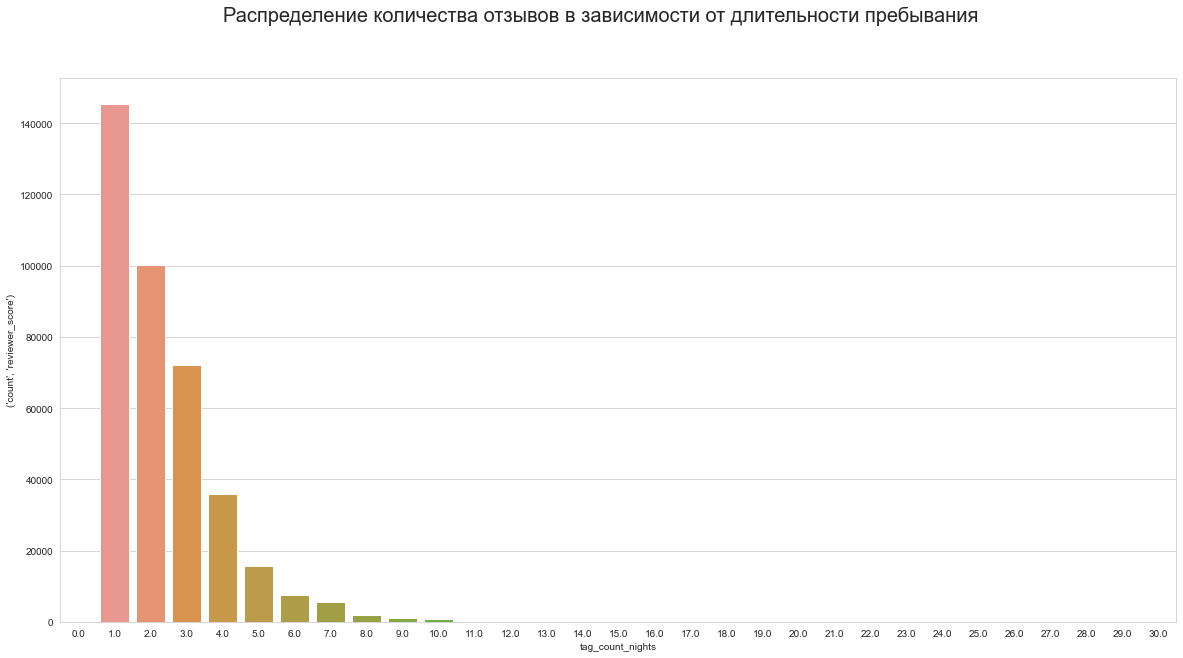

In [39]:
pivot_nights = pd.pivot_table(hotels, index='tag_count_nights', values='reviewer_score', aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(20, 10))
plt.suptitle('Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

***Наибольшие группы - это туристы, совершавшие короткие поездки длительностью 1-3 ночи. Логично, для городских отелей. С возрастанием длительности пребывания - количество отзывов постепенно снижается, а после показателя в 14 ночей (стандартная длина отпуска) - их количество падает резко.***

Странно, что у некоторых данных отсутствует информация о длительности пребывания в отеле. Вообще сайт тщательно проверяет отзывы на реальность.
Возможно это поездки, задним числом аннулированные отелем с возвратом денег туристу, например, а отзыв о пребывании уже был опубликован.
Если обратить внимание на отзывы - то это в основном негативные отзывы.

***А теперь посмотрим, есть ли зависимость средних оценок от категорий номера:***

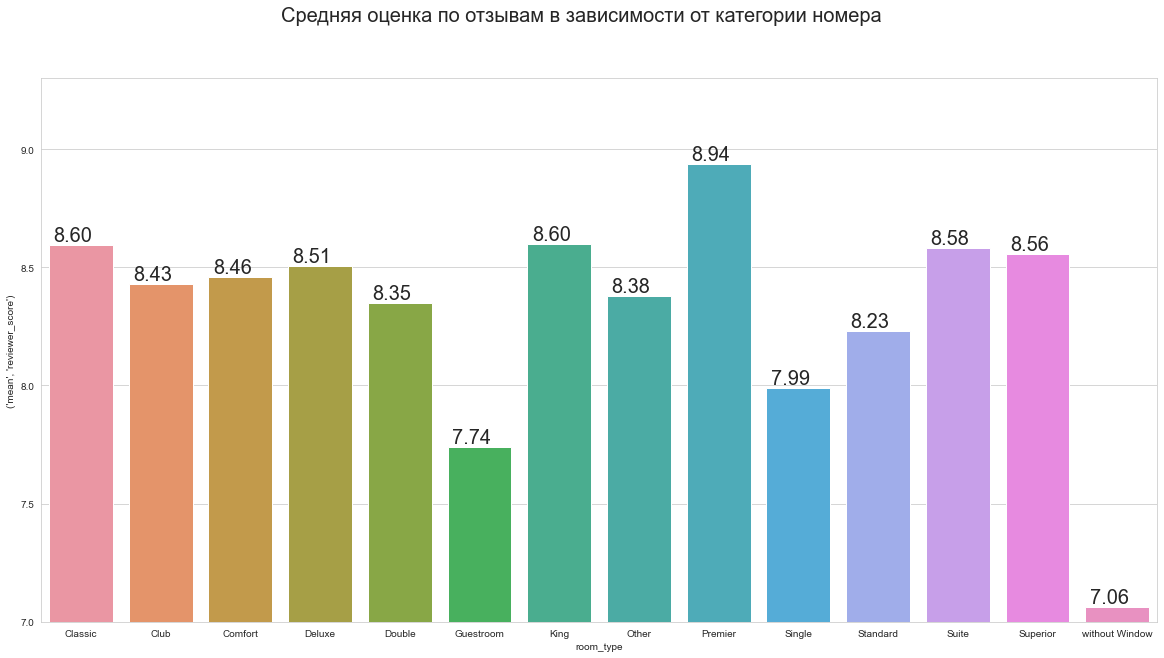

In [40]:
pivot_types = pd.pivot_table(
    hotels, index='room_type', values='reviewer_score', aggfunc=['count', 'mean'])

fig4, ax4 = plt.subplots(figsize=(20, 10))
plt.suptitle('Средняя оценка по отзывам в зависимости от категории номера', size=20)
bar_types = sns.barplot(x=pivot_types.index, y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

Да, без окна действительно, наверно не сладко :D

In [41]:
# удалим вспомогательные столбцы:
hotels.drop(['tag_reviewer_type', 'room_type', 'tag_room_type', 'len_tags'], axis=1, inplace=True)

### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ РЕЦЕНЗЕНТА ('total_number_of_reviews_reviewer_has_given')</span>

Кажется, что такой параметр, как количество отзывов у рецензента - вообще не влияет на оценку отелю. Но возможно, конечно, что более "умудренные опытом" путешественники более требовательны и строги к объекту размещения. Или напротив, люди, которые много путешествуют - лучше знают чего хотят и имеют больше опыта в выборе объекта размещения. А значит, реже разочаровываются... Эти гипотезы нуждаются в проверке. Оставим решение вопроса об удалении на этап анализа и отбора признаков.

In [42]:
print(colored('\nПосмотрим на количество отзывов рецензентов по группам активности:', 'green'))
print(hotels['total_number_of_reviews_reviewer_has_given'].groupby(
    pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], np.arange(0, 360, 25))).agg('count'))

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента:
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))


Посмотрим на количество отзывов рецензентов по группам активности:
total_number_of_reviews_reviewer_has_given
(0, 25]       366215
(25, 50]       16316
(50, 75]        2953
(75, 100]        864
(100, 125]       218
(125, 150]       107
(150, 175]        87
(175, 200]        16
(200, 225]        11
(225, 250]         8
(250, 275]         2
(275, 300]         2
(300, 325]         2
(325, 350]         1
Name: total_number_of_reviews_reviewer_has_given, dtype: int64


## 1.3 ХАРКЕТИРСТИКИ ВРЕМЕНИ - ДАТЫ И ПЕРИОДЫ

***Дата размещения отзыва ('review_date')***

***Разница между датой отзыва и датой выгрузки данных ('days_since_review')***

### <span style="color:blue">ДАТА РАЗМЕЩЕНИЯ ОТЗЫВА ('review_date')</span>

У меня есть гипотеза, что на оценку туриста, параметр безусловно субъективный, часто влияет не только опыт пребывания в отеле, но и атмосфера путешествия в целом.
- Не секрет, что лучшим временем для путешествия в крупные европейские города многие считают период зимних новогодних и рождественских праздников. Улицы европейских мегаполисов превращаются в большие рождественские ярмарки, а в отелях менеджмент часто создает непринужденную праздничную атмосферу. Кажется это сильно должно влиять на общую оценку отелю.
- Весна также прекрасное время для посещения европейских городов. Уже довольно тепло для прогулок, но нет толп назойливых туристов.
- Лето, конечно, спорный период. Это пора отпусков и даже городские отели переполнены. Но долгожданное посещение Парижа или Милана может подпортить жара, например, проблемы с кондиционером, или очереди на завтраке. Персонал часто не справляется с большим потоком посетителей, отсюда, предполагаю что оценки посещения отеля летом будут одними из самых низких.
- Ну и осень. Осенью в Европейских отелях тоже не сладко :D. Начинаются холодные промозглые денечки, в номерах часто холодно и сыро. После летнего туристического сезона именно осенью многие отели устраивают ремонтные работы к рождественским каникулам, что может вызвать дополнительный дискомфорт постояльцев.

Мне кажется, что логичнее всего выделить в отдельные признаки - месяц, неделю и время года посещения отеля.

*PS. В последствии я отказалась от идеи сформировать время года в отдельный признак. И порядковое, и категориальное кодирование сезона года ухудшало итоговый MAPE.*

In [43]:
# преобразуем данные в столбце в формат даты/времени:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# формируем новые признаки:
hotels['review_week'] = hotels['review_date'].apply(lambda x: x.isocalendar().week)
hotels['review_month'] = hotels['review_date'].dt.month

#### <span style="color:green">Визуализируем влияние месяца посещения отеля на средние настроения туристов:</span>

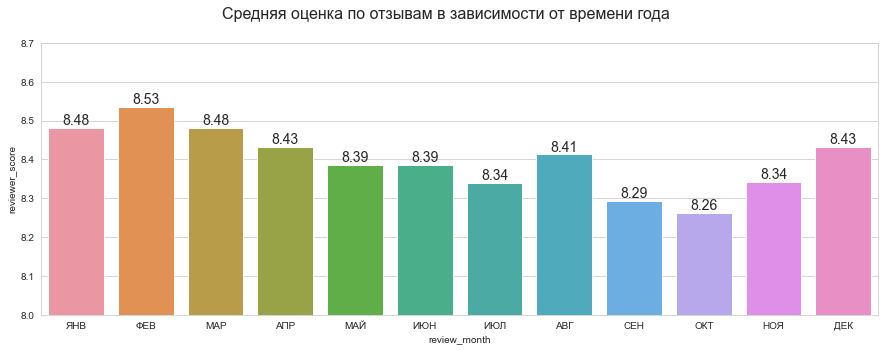

In [44]:
pivot_month = hotels[['review_month', 'reviewer_score']].groupby('review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(x=pivot_month.index, y=pivot_month['reviewer_score'])
ax5.set_xticklabels(['ЯНВ', 'ФЕВ', 'МАР', 'АПР', 'MAЙ', 'ИЮН', 'ИЮЛ', 'АВГ', 'СЕН', 'ОКТ', 'НОЯ', 'ДЕК'])

for p in bar_month.patches:
    bar_month.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

Визуализация предварительно подтверждает гипотетическую связь показателей.

### <span style="color:blue">ВОЗРАСТ ОТЗЫВА В ДНЯХ ПРИ ВЫГРУЗКЕ ДАННЫХ ('days_since_review')</span>

Тут даже предположить не могу - как может возраст отзыва влиять на оценку. Можно выдвинуть гипотезу, разве что, что "раньше люди были добрее". Но так как период давности в наших данных ограничивается всего лишь 2 годами, даже она, по моему не состоятельна :D

Информация о возможной сезонности уже получена из даты, а этот признак удалим, со спокойной совестью, не откладывая до этапа отбора признаков.

In [45]:
hotels.drop('days_since_review', axis = 1, inplace=True)

## 1.4 ОТЗЫВЫ

***Отрицательный отзыв, который рецензент дал отелю ('negative_review')***

***Положительный отзыв, который рецензент дал отелю ('positive_review')***

***Общее количество слов в отрицательном отзыве ('review_total_negative_word_counts')***

***Общее количество слов в положительном отзыве ('review_total_positive_word_counts')***

Структура отзыва об отеле на сайте "Booking.com" устроена таким образом, что содержит в себе две части: Отрицательный отзыв и Положительный отзыв. После выставления оценок по категориям рецензенту предлагается ответить на два вопроса:
- Что вам не понравилось в объекте размещения?
- Что вам понравилось в объекте размещения?

Таким образом получается две части одного по сути отзыва.

### <span style="color:blue">КОЛИЧЕСТВО СЛОВ В ОТЗЫВЕ</span>
### <span style="color:blue">(‘review_total_positive_word_counts’) / (‘review_total_negative_word_counts’)</span>

Если посчитать фактическое количество слов в строке с отзывом - то оно будет отличаться от данных на 1-2 пункта.
А количество слов равное 0 - соответствует меткам 'No Positive' / 'No Negative', то есть фактическому отсутствию отзыва.
Не считаю этот факт критичным и оставляю данные в этом аспекте без преобразований.

***Эти признаки уже напрямую дают нам информацию о том, удовлетворен ли турист пребыванием в отеле. В большинстве случаев, если все было прекрасно, на вопрос: Что вам не понравилось? - вы не ответите ничего или обойдетесь стандартной фразой типа "Все понравилось" или "Все было прекрасно!". Если же есть на что пожаловаться - эта часть отзыва будет длиннее. С положительной частью - то же самое. Проверим эту гипотезу:***

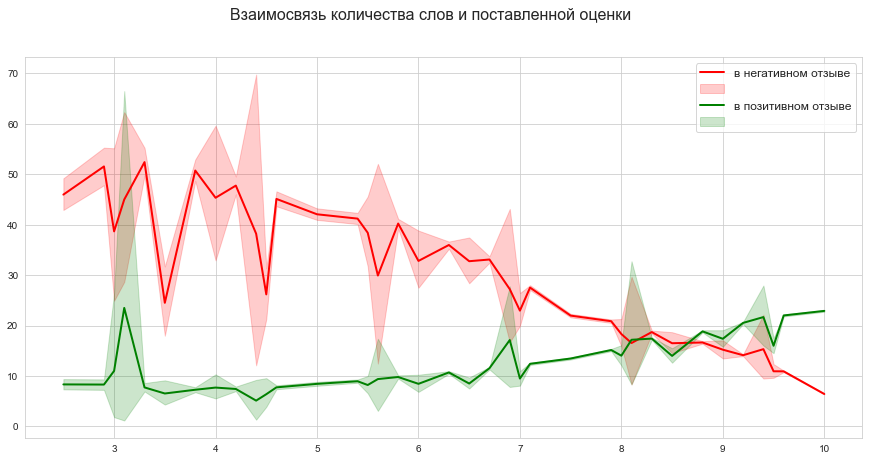

In [46]:
fig6, ax6 = plt.subplots(figsize=(15, 7))
plt.suptitle('Взаимосвязь количества слов и поставленной оценки', size=16)
line_count_neg = sns.lineplot(data=hotels,
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos = sns.lineplot(data=hotels,
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)
ax6.set_xlabel('')
ax6.set_ylabel('')
ax6.legend(['в негативном отзыве', '', 'в позитивном отзыве', ''], loc='upper right', fontsize=12);

На самом деле, зависимость оценки от количества слов отзыве гораздо более сильная, чем может показаться на первый взгляд. Вспоминая систему оценок на сайте, отбросим аномальные значения:


Оценки, укладывающиеся в систему оценивания Booking.com:


10.000    86803
9.600     53502
9.200     44053
8.800     34795
8.300     30903
7.500     26164
7.900     24901
7.100     18529
6.700     14117
6.300     11244
5.800      8962
5.400      7082
5.000      6278
4.600      4660
4.200      3827
3.800      3017
3.300      2063
2.500      1632
2.900      1211
Name: reviewer_score, dtype: int64


Оценки, не укладывающиеся в систему оценивания Booking.com:


9.500    523
9.000    483
8.000    388
8.500    379
7.000    293
6.500    274
6.000    184
5.500    161
4.500     97
4.000     66
3.500     61
9.400     47
8.100     28
3.000     25
6.900     23
5.600     13
4.400      9
3.100      6
Name: reviewer_score, dtype: int64

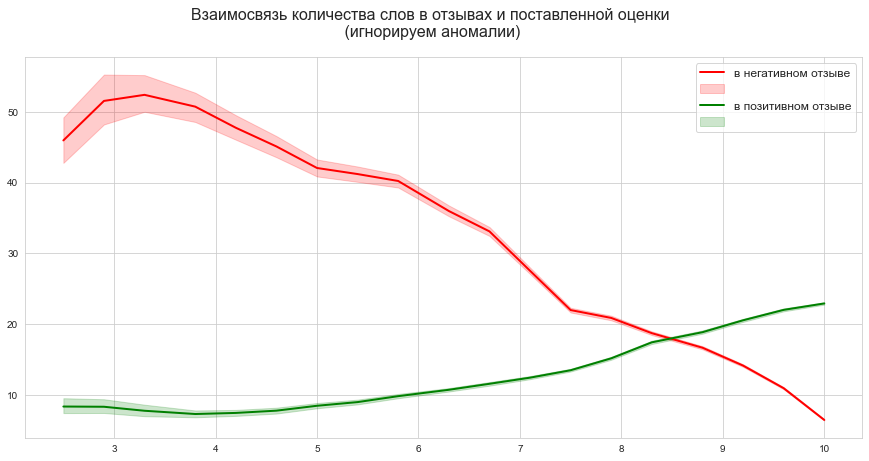

In [47]:
# разделим список всех оценок с их количествами на две части
# 1) те которые укладываются в систему оценки
scores_list_1 = hotels['reviewer_score'].value_counts().iloc[:19]
# 2) остальные
scores_list_2 = hotels['reviewer_score'].value_counts().iloc[19:]

print(colored('\nОценки, укладывающиеся в систему оценивания Booking.com:', 'green'))
display(scores_list_1)

print(colored('\nОценки, не укладывающиеся в систему оценивания Booking.com:', 'green'))
display(scores_list_2)

# а теперь визуализируем связь количества слов в отзыве и уровня оценки, без учета этих 1% аномальных значений:
hotels_filtered = hotels[hotels['reviewer_score'].isin(scores_list_1.index.to_list())]

fig7, ax7 = plt.subplots(figsize=(15, 7))
plt.suptitle('Взаимосвязь количества слов в отзывах и поставленной оценки\n (игнорируем аномалии)', size=16)
line_count_neg_f = sns.lineplot(data=hotels_filtered,
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos_f = sns.lineplot(data=hotels_filtered,
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)
ax7.set_xlabel('')
ax7.set_ylabel('')
ax7.legend(['в негативном отзыве', '', 'в позитивном отзыве', ''], loc='upper right', fontsize=12);

#### Посмотрим на распределения этих признаков:

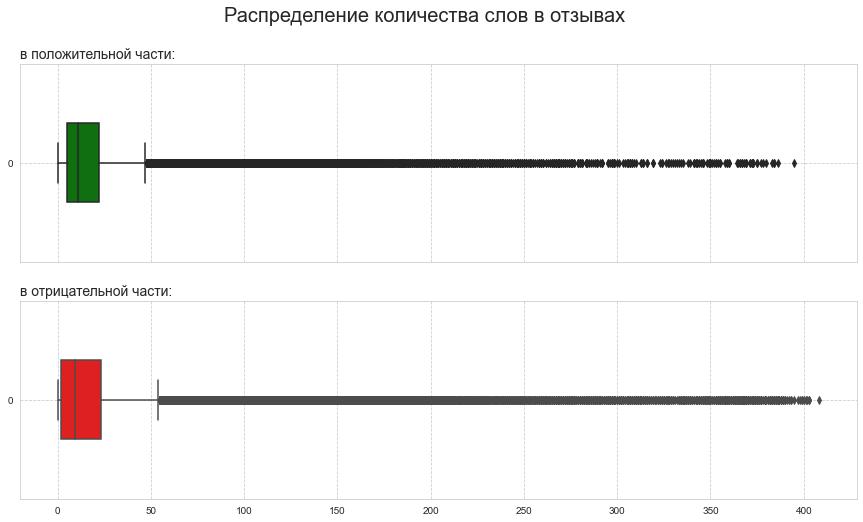

In [48]:
# формируем размеры диаграмм:
fig10, ax10 = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(15, 8))
plt.suptitle('Распределение количества слов в отзывах', size=20)

sns.boxplot(ax=ax10[0], data=hotels['review_total_positive_word_counts'], color='green', width=0.4, orient='h').grid(linestyle='--')
sns.boxplot(ax=ax10[1], data=hotels['review_total_negative_word_counts'], color='red', width=0.4, orient='h').grid(linestyle='--')
ax10[0].set_title('в положительной части:', ha='left', x=.0, fontsize=14)
ax10[1].set_title('в отрицательной части:', ha='left', x=.0, fontsize=14);

Распределения односторонние (похожие на распределения целевого признака), большой разброс значений за пределами границы третьего квартиля - это конечно не аномалии, а специфика этих данных. Взаимодополняющее влияние количества слов в двух частях отзыва - это одна из самых сильных зависимостей в этом датасете.

Сначала у меня были идеи как-то обработать количество слов, ограничить по методу Тьюки или, например, логарифмировать данные. Но не одно их этих преобразований не давало значимого улучшения итоговых метрик, и я от них отказалась. Судя по всему, масштаб каждого вида данных в отдельности - не сильно влияет на предложенный алгоритм построения модели (Random Forest).

Приводить данные к единой размерности есть смысл только, если нужно сделать сравнение их между собой.

Целевая переменная демонстрирует зависимость от обеих величин. Соединим оба эффекта в один, добавив разницу количества слов в позитивной и негативной частях отзыва (предварительно нормализуем обе шкалы):

In [49]:
mm_scaler = MinMaxScaler()

hotels['review_total_positive_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

hotels['review_total_negative_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# соединим эти показатели в один, отрицательные слова - с отрицательным коэффициентом:
hotels['review_total_word_counts_diff_norm'] = hotels['review_total_positive_word_counts_norm'] - hotels['review_total_negative_word_counts_norm']

# а также добавим флаг - преобладают ли позитивные слова над негативными в размерностях соответствующих диапазонов:
hotels['positive_words_more'] = hotels['review_total_word_counts_diff_norm'].apply(lambda x: 1 if x >= 0 else 0)

hotels.drop(['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], axis=1, inplace=True)

Также добавим долю одной из частей (второй показатель будет обратно пропорциональным, очевидно - не значимым):

In [50]:
hotels['review_total_word_counts'] = hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными (по 0.5):
hotels['review_positive_word_proportion'] = hotels.apply(
    lambda row: 0.5 if row['review_total_word_counts'] == 0 else row['review_total_positive_word_counts'] / row['review_total_word_counts'],
axis=1)

# удаляем вспомогательный столбец:
hotels.drop('review_total_word_counts', axis = 1, inplace=True)

### <span style="color:blue">НЕПОСРЕДСТВЕННО ОТЗЫВ (‘negative_review’, ‘positive_review’)</span>

А теперь - самое интересное:D

Огромное количество информации для лучшего предсказания итоговой оценки содержится именно в этих столбцах!
Но для того чтобы параметрически оценить эти данны - нужен будет лингвистический анализ текста. Проведя несколько часов в различных поисковых системах, я останавливаюсь на самых распространенных и одних из самых простых для новичка библиотеках:

1) VADER (Valence Aware Dictionary and sEntiment Reasoner) — это основанный на лексике и правилах инструмент анализа настроений, специально настроенный на чувства, выраженные в социальных сетях.
<a href="https://github.com/cjhutto/vaderSentiment">Библиотека на GitHub тут</a>

2) TextBlob — это библиотека Python (2 и 3) для обработки текстовых данных. Он предоставляет простой API для погружения в общие задачи обработки естественного языка (NLP), такие как тегирование частей речи, извлечение именной фразы, анализ тональности, классификация, перевод и многое другое.
<a href="https://textblob.readthedocs.io/en/dev/">Ссылка на сайт библиотеки тут</a>
<a href="https://buildmedia.readthedocs.org/media/pdf/textblob/latest/textblob.pdf">Документация TextBlob</a>

3) Собственные идеи классификации текста

4) Я просто не могла остановиться...


Начнем это увлекательнейшее исследование с красивой визуализации самых популярных слов (она стоит следующих 30 строчек кода):

In [51]:
# визуализируем основные слова положительных и отрицательных частей отзывов
# загружаем словарь для лемматизации
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
w_tokenizer = tokenize.WhitespaceTokenizer()
lemmatizer = stem.WordNetLemmatizer()

# очистка и лемматизация текста:
def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    return text

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# визуализация словарных наборов:
def get_words_string(words_data):
    words_string = ''
    for word in words_data:
        words_string = words_string + word + ' '
    return words_string

# рисуем диаграмму:
def draw_cloud(text_column, background, color_map):
    hotels['temp'] = hotels[text_column].apply(lambda x: x.replace('No Negative', '').replace('No Positive', ''))
    hotels.temp = hotels[text_column].apply(clean_text)
    hotels.temp = hotels[text_column].apply(lemmatize_text)
    cloud_data = hotels.temp.apply(get_words_string)
    # воспользуемся функцией для визуализации тегов:
    show_wordcloud(cloud_data, background, color_map)

ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:



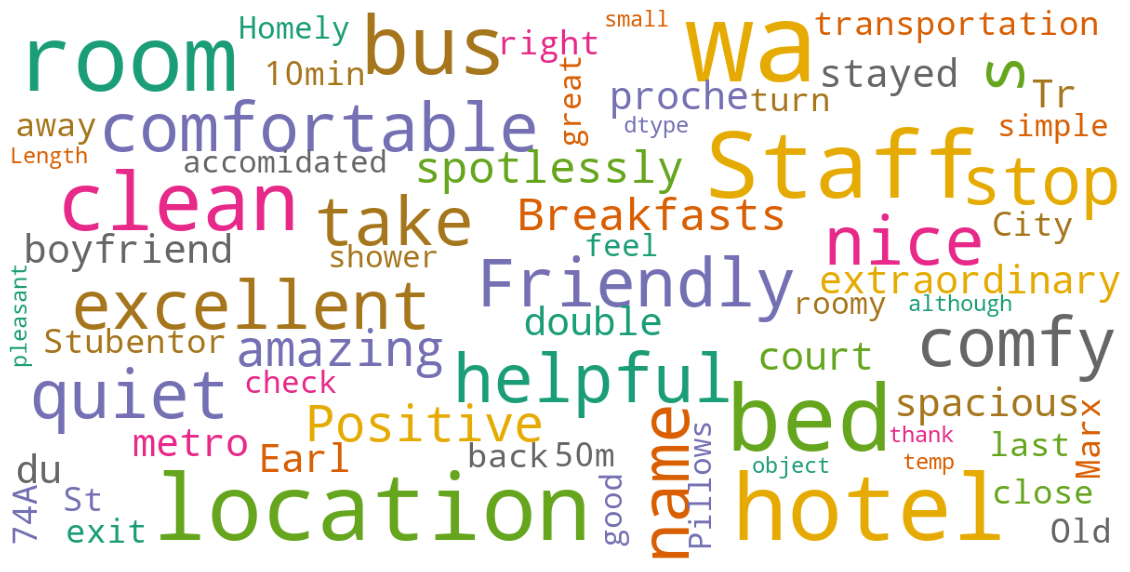

In [52]:
print('ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('positive_review', 'white', 'Dark2');

ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:



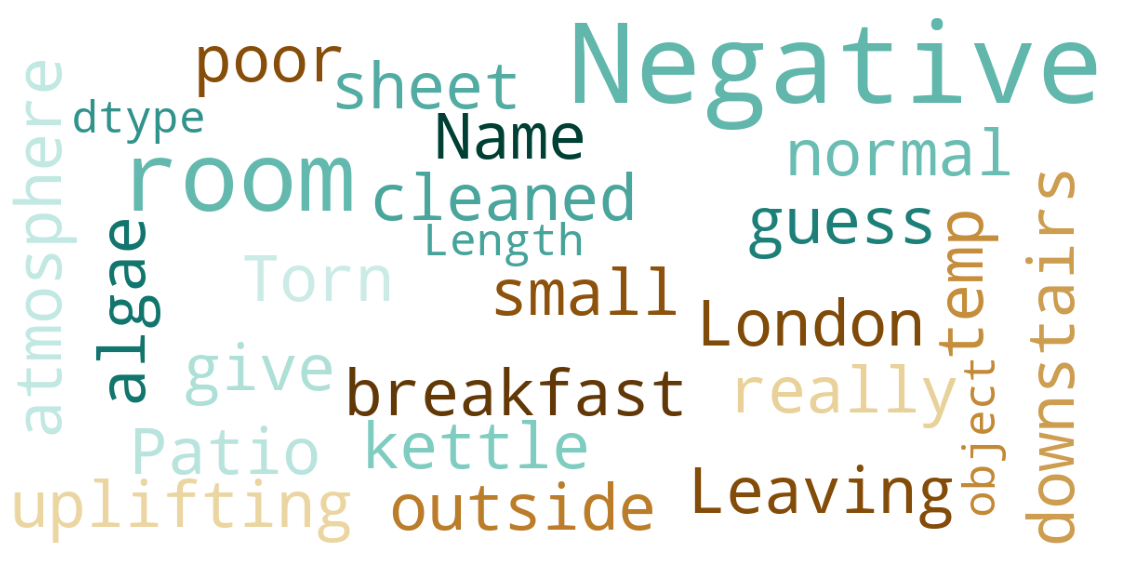

In [53]:
print('ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('negative_review', 'white', 'BrBG');

### Анализ настроений с помощью SentimentIntensityAnalyzer (nltk VADER):

SentimentIntensityAnalyzer выводит оценку на 3 уровнях классификации, а также составную оценку.
В результате мы получим словарь нормализованных оценок тональности текста по категориям:
- негативная оценка
- нейтральная оценка
- позитивная

И все бы хорошо, но одни и те же слова в положительном и отрицательном контекстах будут иметь противоположную тональность.


### "Все" или "Ничего"?

Вспомним, что положительный и отрицательные части отзыва  - это ответы на два вопроса сайта о том что понравилось / не понравилось в отеле. А структура английского языка такова (как выяснилось), что ответ на вопрос "Что вам не понравилось?": "Ничего" (nothing) - будет означать, что ничего не не понравилось, то есть - все понравилось. Самый положительный контекст. Но тоже самое "Ничего" в ответ на вопрос: "Что вам понравилось?" будет означать ровно обратное.

А вот слово "все" (everything) такой семантики не имеет (но это не точно).

Эти слова изначально для анализатора имеют нейтральную тональность, но в качестве ответа на вопрос, хорошо было бы эту тональность именно таких самых популярных ответов изменить. Причем разным образом для разных частей отзывов.

Так же слово "small" мы встретим в огромной части отрицательных отзывов - Small room, Small bed, Small pool. И невинно нейтральное small в отрицательных отзывах об отелях принимает негативный контекст.

Для работы с разными частями отзывов я создам два разных анализатора - SentimentIntensityAnalyzer, а лексикон каждого настрою для соответствующей части отзывов.

И еще один момент. Вообще метками 'No Negative' / 'No Positive' обозначается отсутствие отзыва. Если оставить все как есть, то анализатор отбросив "No", выдаст тональность противоположного по значению слова. Можно вообще удалить эти значения, заменив на пустую строку, но для нас отсутствие отрицательно  отзыва - означает - отсутствие отрицательного опыта пребывания и наоборот, по этому оставим эти фразы для анализа, предварительно переформулировав фразы без "не". А вот если не написано вообще ничего, то взаимные разнонаправленные тональности обеих меток в сумме дадут нейтральный 0.

In [54]:
# создаем два экземпляра анализатора, чтобы разделить лексикон для оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований: {sia_neg.polarity_scores(example)}')

# добавим контекст:  !!!!!!!!!!!!!!!!!!!!!!!!!!!!! ПРОВЕРИТЬ!: завтрак
# по всей видимости негативный и позитивный индекс присваивается по логарифмической шкале, поэтому, разграничим величину позитивного / негативного контекста числом разрядов:
neg_words = {'nothing': 10, 'small': -1,}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного отзыва): {sia_neg.polarity_scores(example)}')
print(f' - после преобразований (для позитивного отзыва): {sia_pos.polarity_scores(example)}')

# фразы "No Negative" тонально будет нести негативную окраску (так как "No" при анализе отбрасывается):
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}": {sia_neg.polarity_scores(example)}')
example = 'Positive'
print(f'Словарь оценок фразы "{example}": {sia_neg.polarity_scores(example)}')

# меняем метки отсутствия частей отзыва
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 - после преобразований (для негативного отзыва): {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного отзыва): {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative": {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive": {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [55]:
%%time

# понеслась?)
hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(lambda x: sia_pos.polarity_scores(x))
# кстати, не очень долго считает (толи еще будет!)

CPU times: user 2min 37s, sys: 1.11 s, total: 2min 38s
Wall time: 2min 40s


In [56]:
# формируем новые признаки:
hotels['negative_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(lambda x: x['neg'])
hotels['negative_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(lambda x: x['neu'])
hotels['negative_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(lambda x: x['pos'])
hotels['negative_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(lambda x: x['compound'])

hotels['positive_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(lambda x: x['neg'])
hotels['positive_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(lambda x: x['neu'])
hotels['positive_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(lambda x: x['pos'])
hotels['positive_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(lambda x: x['compound'])

### Анализ настроений с помощью TextBlob:

TextBlob работает немного по другому. В отличие от Vader, он анализирует не слова, а фразы и предложения, выдавая такие параметры как: полярность и субъективность.

Полярность — это число с плавающей запятой от -1 до 1, где -1 — отрицательное утверждение, а 1 — положительное утверждение.
Субъективность — это показатель TextBlob, определяющий, считается ли утверждение в большей степени личным мнением или оно основано на фактах.

Для оценки настроения рецензента будем использовать параметр полярности.

Также при помощи NaiveBayesAnalyzer можно получить классификацию настроений (аналогичную Vader) в негативной и позитивной частях отзыва и, на основе этих данных выведем категорию отзыва, руководствуясь следующей логикой:

***- (восторженный) обе части имеют позитивную тональность: высшая категория***
туристу так все понравилось, что и в ответе на вопрос о недостатках - он выражает положительные эмоции

***- (конструктивный) позитивная часть имеют позитивную тональность, негативная часть - негативную: средняя высокая категория***
объективный поиск достоинств и недостатков отеля

***- (снисходительный) позитивная часть имеет негативную тональность, негативная - позитивную: средняя низкая категория***
пребывание скорее не понравилось, но отзыв о недостатках не жесткий

***- (разочарованный) обе части имеют негативную тональность: низшая категория***
ничего не понравилось

Исходя из шкалы оценивания отеля - выберем 4 оценки в диапазоне от 2.5 до 10 с равным шагом.

In [57]:
# так как этот анализатор работает не со словами, а с фразами, то он справляется с выражениями 'No Negative' / 'No Positive':
text_example = 'No Negative'
example = TextBlob(text_example)
print(f'Полярность фразы "{text_example}": {round(example.sentiment_assessments.polarity,2)}')

text_example = 'No Positive'
example = TextBlob(text_example)
print(f'Полярность фразы "{text_example}": {round(example.sentiment_assessments.polarity,2)}')

# а вот у 'nothing' полярность нейтральная:
text_example = 'nothing'
example = TextBlob(text_example)
print(f'\nПолярность слова "{text_example}": {round(example.sentiment_assessments.polarity,2)}')

# но так как есть огромное количество коротких ответов на вопрос что понравилось? / не понравилось?
# именно словами 'nothing' и 'everything' - меняем их на соответствующие уровню эмоциональной окраски метки:
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.lower().replace('nothing', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.lower().replace('everything', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review_temp'].apply(lambda x: x.replace('nothing', 'Negative'))

Полярность фразы "No Negative": 0.15
Полярность фразы "No Positive": -0.11

Полярность слова "nothing": 0.0


In [58]:
%%time
def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity


hotels['negative_polarity'] = hotels['negative_review_temp'].apply(get_polarity)
hotels['positive_polarity'] = hotels['positive_review_temp'].apply(get_polarity)

# ну вот, уже не так быстро)

CPU times: user 4min 10s, sys: 913 ms, total: 4min 11s
Wall time: 4min 12s


In [59]:
%%time
tb = Blobber(analyzer=NaiveBayesAnalyzer())

text_example = 'everything was great'
print(f'{tb(text_example).sentiment} для фразы "{text_example}"')

# так как позитивный и негативный компонент - взаимно обратные величины, образующие в сумме 1 -
# можно ограничится только одним:
def get_tb_sentiment(text):
    tb_sentiment = tb(text).sentiment
    return tb_sentiment[1]

hotels['positive_review_pos'] = hotels['positive_review_temp'].apply(get_tb_sentiment)
hotels['negative_review_pos'] = hotels['negative_review_temp'].apply(get_tb_sentiment)

# добавим отзыву классификацию в зависимости от доли положительного компонента:
hotels['positive_review_class'] = hotels['positive_review_pos'].apply(lambda x: 1 if x >= 0.5 else 0)
hotels['negative_review_class'] = hotels['negative_review_pos'].apply(lambda x: 1 if x >= 0.5 else 0)

Sentiment(classification='pos', p_pos=0.6252594845412645, p_neg=0.37474051545873566) для фразы "everything was great"
CPU times: user 3min 7s, sys: 1.01 s, total: 3min 8s
Wall time: 3min 9s


In [60]:
# добавляем параметр с классификацией отзыва:
def get_review_classification(positive_review_class, negative_review_class):
    if positive_review_class + negative_review_class == 2:
        return 10.0
    if positive_review_class == 1 and negative_review_class == 0:
        return 7.5
    if positive_review_class == 0 and negative_review_class == 1:
        return 5.0
    return 2.5

hotels['review_classification'] = hotels.apply(
    lambda row: get_review_classification(row['positive_review_class'], row['negative_review_class']), axis=1)

### Собственные эксперименты:

Предыдущими методами мы получили несколько классификаций, основанных на анализе настроений, но не учитывающих специфический лексикон рецензентов, пишущих именно об отелях. На самом деле, есть куча конструктивных отзывов, описывающих достоинства обстоятельно, но без сильных эмоций. И хочется понять, что рецензент рассуждает об отеле в ключе самых хвалебных отзывов.

Я попробовала найти простой способ сравнить все отзывы с лучшими и выявить какой-то коэффициент похожести. Но как понять, какие - лучшие?
(Кстати с отрицательными отзывами - этот подход не сработал, так как люди пишут отрицательные отзывы более обстоятельно, даже если не сильно снижают оценку)

Я попробую создать некий набор слов типичных для положительных отзывов, основываясь на положительной части отзывов о лучших отелях (с самым высоким среднем рейтингом). Потом оценим, какой процент слов каждого отзыва пересекается с этим набором.

In [61]:
%%time

# формируем единый блок текста обеих частей отзыва и избавляемся от меток отсутствия слов:
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', ''))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']

# функция преобразования строки в набор слов:
def get_words_set(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if len(word) > 2]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    words_data = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    words_set = set()
    for word in words_data:
        words_set.add(word)
    return words_set

# формируем наборы уникальных слов каждого отзыва:
hotels['review_word_set'] = hotels['review'].apply(get_words_set)

# зато быстро!

CPU times: user 1min 5s, sys: 643 ms, total: 1min 6s
Wall time: 1min 7s


In [62]:
best_words_set = set()

# подберем образцы текста отзывов лучших отелей
hotels_top = pd.DataFrame(hotels[hotels['average_score'] >= 9.6])
hotels_top['positive_review_word_set'] = hotels_top['positive_review'].apply(get_words_set)
hotels_top_list = hotels_top['positive_review_word_set'].tolist()

for review_set in hotels_top_list:
    best_words_set.update(review_set)

best_hotels_count = len(hotels[hotels['average_score'] >= 9.6]['hotel_name'].value_counts())

print(f'Количество уникальных слов, отобранное по результатам {len(hotels_top_list)} отзывов '
      f'{best_hotels_count} лучших отелей: {len(best_words_set)}.')

Количество уникальных слов, отобранное по результатам 712 отзывов 7 лучших отелей: 1763.


In [63]:
def get_difference_with_top(review_words_set):
    set_len = len(review_words_set)
    if set_len == 0:
        return 0
    top_words_count = 0
    for word in review_words_set:
        if word in best_words_set :
            top_words_count += 1

    return round(top_words_count / set_len, 2)

# формируем новый признак:
hotels['review_difference_with_top'] = hotels['review_word_set'].apply(get_difference_with_top)

Еще добавлю флаг для отзывов, негативная часть которых содержит короткий ответ, обозначающий, что нет ничего, чтобы не понравилось в отеле:

In [64]:
# я посмотрела 100 самых популярных коротких фраз в негативной части отзыва и выделила те, которые имеют эмоциональное значение:
positive_in_negative_review_list = [
    'nothing', 'nothing really', 'nothing to dislike', 'nothing at all', 'nothing to complain about',
    'nothing all good', 'nothing in particular', 'there was nothing i didn t like', 'absolutely nothing',
    'everything', 'everything was great', 'everything was perfect', 'liked everything', 'everything was good',
    'сan t think of anything', 'i liked everything', 'everything was fine', 'no complaints', 'having to leave',
    'all good', 'all was good', 'no thing', 'none', 'nil', 'na', 'no', 'n a', 'no negative'
]

# в позитивной, меньше вариантов:
negative_in_positive_review_list = ['nothing', 'not much', 'no positive']

hotels['positive_in_negative_review'] = hotels['negative_review'].apply(
    lambda x: 1 if x.strip().lower() in positive_in_negative_review_list else 0)

hotels['positive_in_negative_review'] = hotels.apply(
    lambda row: 1 if row['negative_review'].strip().lower().startswith('nothing') else row['positive_in_negative_review'],
    axis=1)

hotels['negative_in_positive_review'] = hotels['positive_review'].apply(
    lambda x: 1 if x.strip().lower() in negative_in_positive_review_list else 0)

### Бонус! Короткий код с Afinn:

На самом деле, решений задач сентимент-анализа - огромное множество, куча библиотек и разных анализаторов. Те, которые использовала я - наверно самые популярные и довольно понятные новичку.

Однако, блуждая по бескрайним просторам интернета, я наткнулась еще на один лаконичный и простой способ получить коэффициент настроения текста.
Afinn — это подход к анализу настроений на основе списка слов. Он не нормализует оценки и мы получаем коэффициент, соотносимый с масштабом количества слов отзыва. То есть, своего рода взвешенную по количеству слов оценку:

In [65]:
# объединяем обе части отзыва в одну:
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']

In [66]:
%%time
# получаем счет:
afinn = Afinn()
hotels['afinn_score'] = hotels['review'].apply(lambda x: afinn.score(x))

CPU times: user 5min 50s, sys: 1.41 s, total: 5min 51s
Wall time: 6min


#### <span style="color:green">Визуализируем соотношение оценок туристами и коэффициентов afinn:</span>

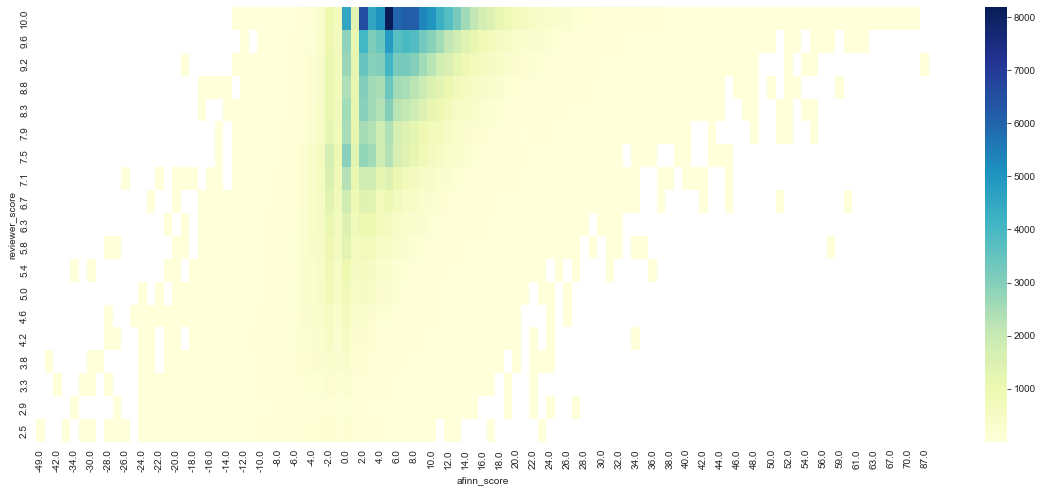

In [67]:
# красивая тепловая карта под конец раздела:
pivot = hotels[hotels['reviewer_score'].isin(scores_list_1.index.to_list())].pivot_table(
    values='review', index='reviewer_score', columns='afinn_score', aggfunc='count')

# строим диаграмму:
fig8, ax8 = plt.subplots(1, 1, figsize = (20, 8))
afinn_heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
ax8.invert_yaxis();

In [68]:
# ограничим размеры диапазона значений по методу Тьюки:
def get_outliers_bonds(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


lower_bound, upper_bound = get_outliers_bonds(hotels, 'afinn_score')

hotels['afinn_score'] = hotels['afinn_score'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

#### ***Ну и самый-самый последний метод обработки текста.***

#### ***Sentence библиотеки Flair (самый медленный - но самый лучший)***

In [69]:
# подготовим данные для анализа:
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', ''))

# этот анализатор (как и любой другой) не может уловить тональность слова "Ничего" без контекста
# он не понимает, что это ответ на вопрос - что вам не понравилось?
# поэтому нам придется заменить самые популярные короткие ответы на близкий по смыслу и понятный анализатору:
hotels['negative_review_temp'] = hotels['negative_review_temp'].apply(
    lambda x: 'i liked everything' if x.strip().lower() in positive_in_negative_review_list else x)

hotels['positive_review_temp'] = hotels['positive_review_temp'].apply(
    lambda x: 'i did not like anything' if x.strip().lower() in negative_in_positive_review_list else x)

hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']

# формируем список отзывов:
reviews = hotels['review'].to_list()

С помощью этой библиотеки мы формируем объект - сентенция, затем получаем категорию текста (позитивная, негативная) и нормализованную оценку интенсивности.

Этот парень оказался самым медленным из всех. Не просто медленным, а невероятно медленным. Я нашла способ заставить работать его чуть быстрее, формируя блоки по 16, но это не сильно помогло. 50 тысяч отзывов обрабатывается примерно 30-35 минут. Чтобы обработать всю базу нужно пару-тройку часов) Повторять это "удовольствие" не очень хотелось, поэтому я формировала отчеты по группам из 75 тысяч отзывов и складывала их в csv файлы.

По-этому, ниже я приведу код с помощью которого формировались данные. А работать буду с выгруженными файлами csv.
(в текстовой ячейки код отображается без отступов, но при копировании - все нормально)


- первый блок - (0-75k)
- второй блок - (75k - 150k)
- третий блок - (150k - 225k)
- четвертый блок - (225k - 300k)
- пятый блок - (300k + )

from collections import defaultdict
from flair.models import TextClassifier
from flair.data import Sentence

start, ehd = 0, 75000

review_list = reviews[start:end]

sentences = list()
for review in review_list:
    sentences.append(Sentence(review))

scores = defaultdict(float)
values = defaultdict(str)
i = 0

classifier = TextClassifier.load('en-sentiment')
classifier.predict(sentences, mini_batch_size=16)

for sentence in sentences:
    if len(sentence) == 0:
        scores[i] = 0
        values[i] = ''
    else:
        scores[i] = sentence.labels[0].score
        values[i] = sentence.labels[0].value
    i += 1

df_sentences = pd.DataFrame({'score': scores, 'value': values})
df_review = pd.DataFrame(review_list, columns = ['review'])
df_sentences['review'] = df_review
df_sentences.to_csv('data_sentences_0k_75k.csv')


In [70]:
# соединим полученные данные в единую базу:
data_sentences_0_75k = pd.read_csv('data/data_sentences_0_75k.csv')
data_sentences_75_150k = pd.read_csv('data/data_sentences_75_150k.csv')
data_sentences_150_225k = pd.read_csv('data/data_sentences_150_225k.csv')
data_sentences_225_300k = pd.read_csv('data/data_sentences_225_300k.csv')
data_sentences_300k_to_end = pd.read_csv('data/data_sentences_300k_to_end.csv')

data_sentences = pd.concat([data_sentences_0_75k,
                            data_sentences_75_150k,
                            data_sentences_150_225k,
                            data_sentences_225_300k,
                            data_sentences_300k_to_end], axis=0)

# проверяем:
print(data_sentences.iloc[145672]['review'])
print()
print(hotels.iloc[145672]['review'])

 Great staff they made the hotel fantastic The breakfast team were efficient and so attentive Every member of staff I walked past acknoledged me said hello Great training and a great team   The hotel and staff were great if a little let down by the concierge on Saturday 18th June morning not very guest focused and slightly rude unlike he rest of the team 

 Great staff they made the hotel fantastic The breakfast team were efficient and so attentive Every member of staff I walked past acknoledged me said hello Great training and a great team   The hotel and staff were great if a little let down by the concierge on Saturday 18th June morning not very guest focused and slightly rude unlike he rest of the team 


In [71]:
# добавляем полученные данные в базу:
sentences_values = data_sentences['value'].to_list()
hotels['sentences_values'] = sentences_values

sentences_scores = data_sentences['score'].to_list()
hotels['sentences_scores'] = sentences_scores

# меняем значение на бинарный признак:
hotels['sentences_values'] = hotels['sentences_values'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# добавляем коэффициент к значению:
hotels['sentences_scores'] = hotels.apply(
    lambda row: row['sentences_scores'] if row['sentences_values'] == 1 else row['sentences_scores'] * -1, axis=1)

# 2. Анализ и отбор признаков (FEATURE SELECTION):

In [84]:
X_df = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score']

In [85]:
print(f'Текущее получившееся количество признаков: {len(X_df.columns)}.')

# удалим нечисловые данные:
object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | (hotels[s].dtypes == 'category') | (hotels[s].dtypes == 'datetime64[ns]'))]

print(f'Удалим {len(object_columns)} столбцов с нечисловыми данными.')
X_df = X_df.drop(object_columns, axis = 1)

Текущее получившееся количество признаков: 83.
Удалим 17 столбцов с нечисловыми данными.


### Разделим числовые признаки на группы:

In [86]:
# непрерывные и категориальные признаки:
num_cols = [
    # признаки связанные с количеством слов:
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'review_total_word_counts_diff_norm', 'review_positive_word_proportion',

     # признаки, связанные с анализом эмоциональной окраски отзывов:
    'negative_review_sentiments_neg', 'negative_review_sentiments_neu',
    'negative_review_sentiments_pos', 'negative_review_sentiments_compound',
    'positive_review_sentiments_neg', 'positive_review_sentiments_neu',
    'positive_review_sentiments_pos', 'positive_review_sentiments_compound',
    'negative_polarity', 'positive_polarity', 'afinn_score', 'sentences_scores',
    'negative_review_pos', 'positive_review_pos', 'review_difference_with_top',

    # остальные количественные:
    'total_number_of_reviews_reviewer_has_given', 'tag_count_nights',
    'additional_number_of_scoring', 'total_number_of_reviews',
]

cat_cols = [
    # характеристики отеля
    'average_score', 'hotel_code', 'hotel_country_code', 'district_code', 'district_rating', 'hotel_distance_to_center',

    # характеристики поездки (номер):
    'tag_leisure_trip', 'tag_view_room', 'room_type_without Window', 'room_type_Suite', 'room_type_Standard', 'room_type_Double',
    'room_type_Superior', 'room_type_Club', 'room_type_Comfort', 'room_type_Deluxe', 'room_type_Premier',
    'room_type_Classic', 'room_type_King', 'room_type_Single', 'room_type_Guestroom', 'room_type_Other',

    # характеристики рецензента:
    'reviewer_en', 'reviewer_n_est', 'reviewer_resident', 'reviewer_nationality_cat', 'tag_from_mobile', 'tag_with_pet',
    'tag_reviewer_type_1.0', 'tag_reviewer_type_2.0', 'tag_reviewer_type_3.0',
    'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0',

    # время поездки:
    'review_week', 'review_month',

    # характеристики отзыва:
    'review_classification', 'positive_words_more', 'negative_review_class', 'positive_review_class',
    'positive_in_negative_review', 'negative_in_positive_review', 'sentences_values'
]

In [89]:
# проведем стандартизацию признаков:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_df_ss = ss.fit_transform(X_df)
X_df = pd.DataFrame(X_df_ss, columns=X_df.columns)

## 2.1 АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ

Поскольку признаков очень много оценим коллинеарность по смысловым группам:

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ НЕПРЕРЫВНЫХ ПРИЗНАКОВ

In [90]:
# создаем функцию для построения корреляционной диаграммы:
def show_corr_heatmap(columns_list, title):
    fig_, ax_ = plt.subplots(figsize=(20, 15))
    corr = hotels[columns_list].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, annot=True, linewidths=0.1, ax=ax_, mask=mask, cmap='viridis')
    ax_.set_title(title, fontsize=18)
    plt.show()

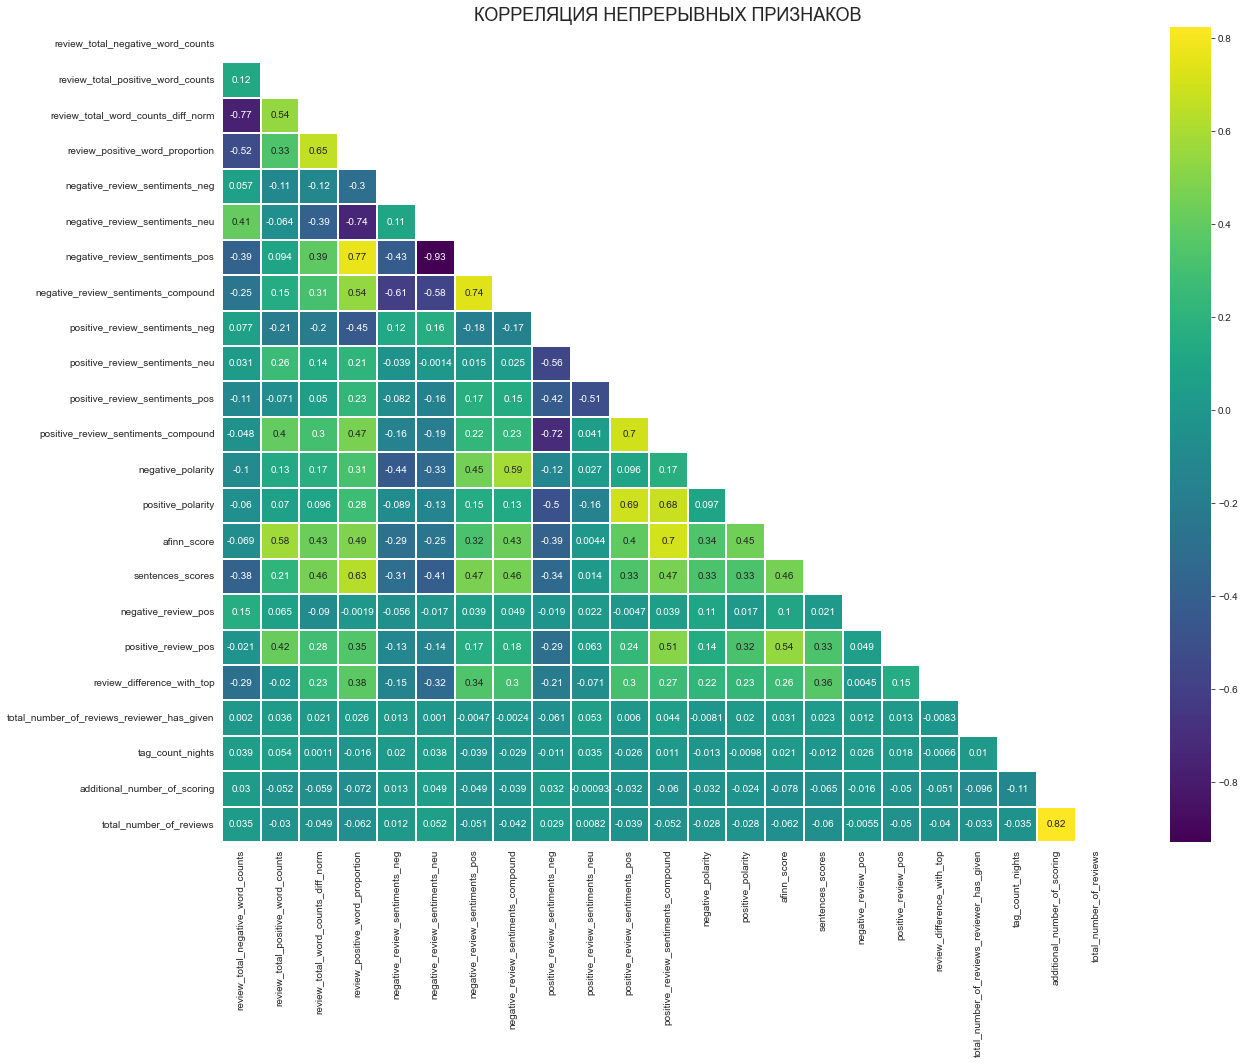

In [91]:
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(num_cols, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ');

***Отбираем на удаление два признака из пар имеющих модуль корреляции больше 0.8.***

In [92]:
# внесем столбцы в список на удаление:
drop_columns = []
drop_columns += ['negative_review_sentiments_neu', 'additional_number_of_scoring']

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Разделим категориальные признаки на 2 смысловые группы:

In [93]:
# в первый блок отнесем характеристики отеля и номера:
cat_cols_p1 = cat_cols[:22]

# во второй блок - характеристики рецензента, времени поездки и отзыва:
cat_cols_p2 = cat_cols[22:]

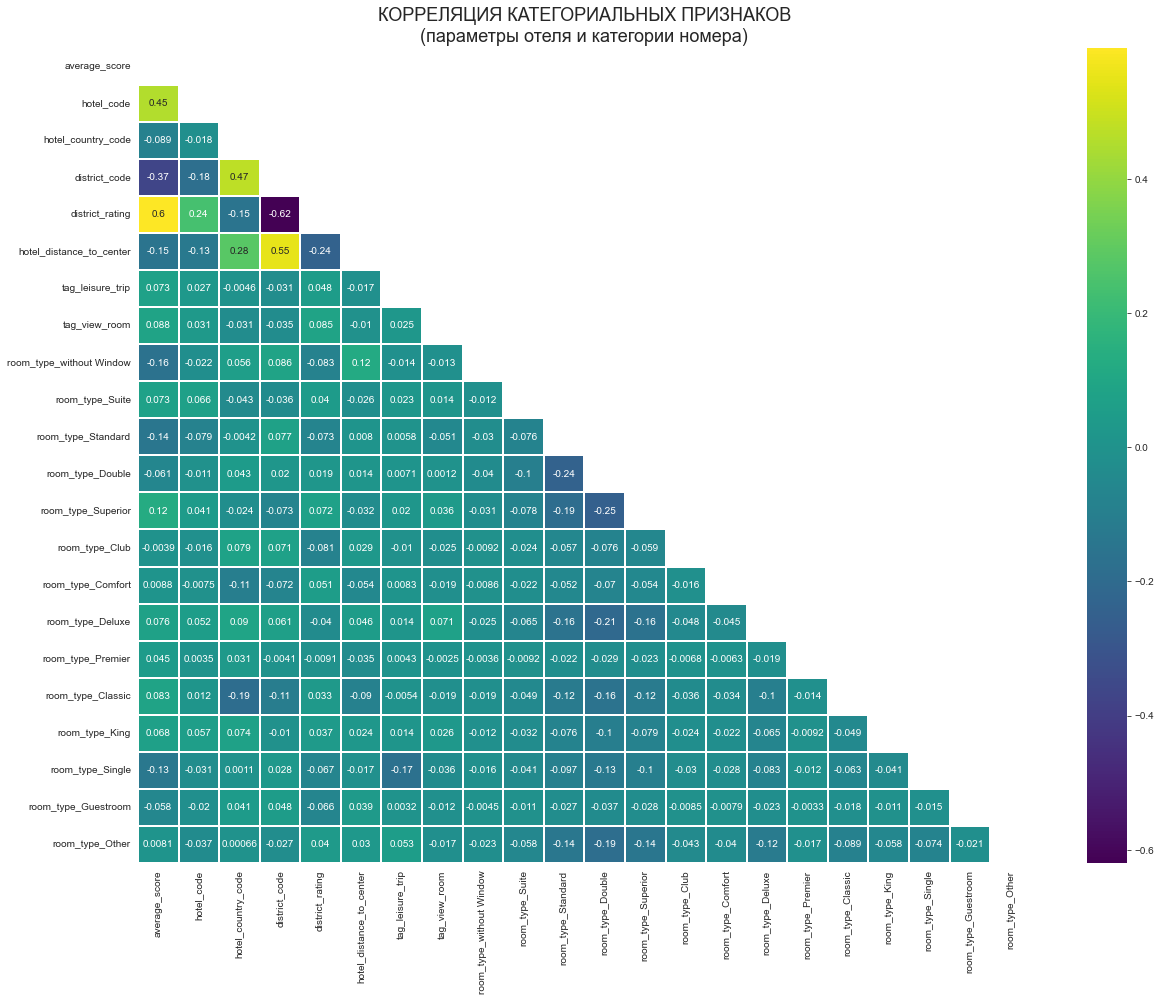

In [94]:
# строим диаграмму для первой части категориальных признаков:
show_corr_heatmap(cat_cols_p1, 'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ\n(параметры отеля и категории номера)');

***Здесь критически сильных корреляций нет***

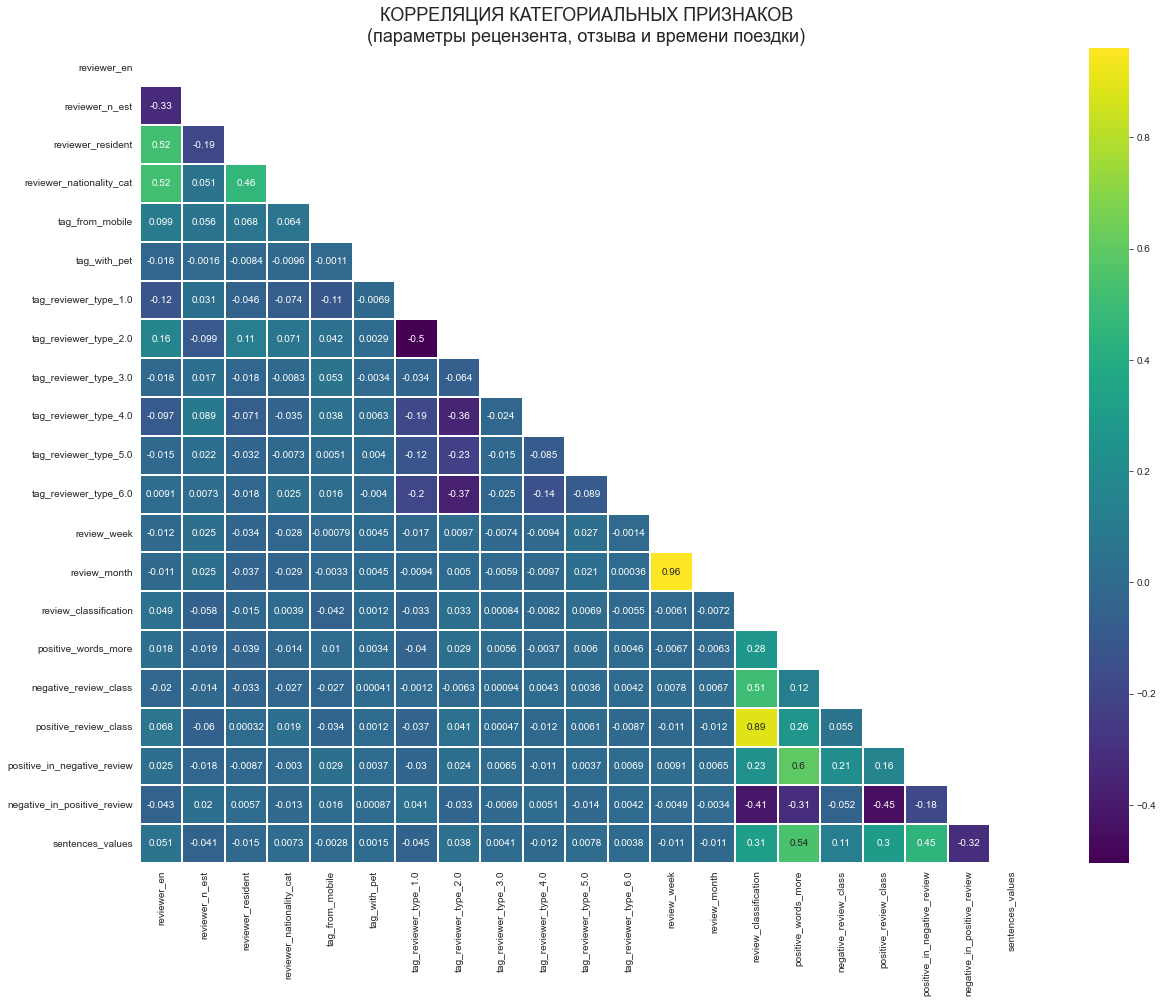

In [95]:
# строим диаграмму для первой части категориальных признаков:
show_corr_heatmap(cat_cols_p2, 'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ\n(параметры рецензента, отзыва и времени поездки)');

***А из этого списка можно удалить признак недели или месяца (удалим месяц) и классификацию отзыва (он сильно коррелирует с признаками из которых выведен).***

In [96]:
# внесем столбцы в список на удаление:
drop_columns += ['review_month', 'review_classification']

In [97]:
# удалим выбранные столбцы:
X_df = X_df.drop(drop_columns, axis = 1)

print(f'Текущее получившееся количество признаков: {len(X_df.columns)}.')

Текущее получившееся количество признаков: 62.


## 2.2 ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Проведем оценку значимости признаков.
Я бы отнесла наш целевой признак к категории - количественный дискретный. Воспользуемся для оценки дисперсионным анализом ANOVA.

Теперь делить признаки на группы не корректно, нам нужно получить абсолютно худшие во всей совокупности:

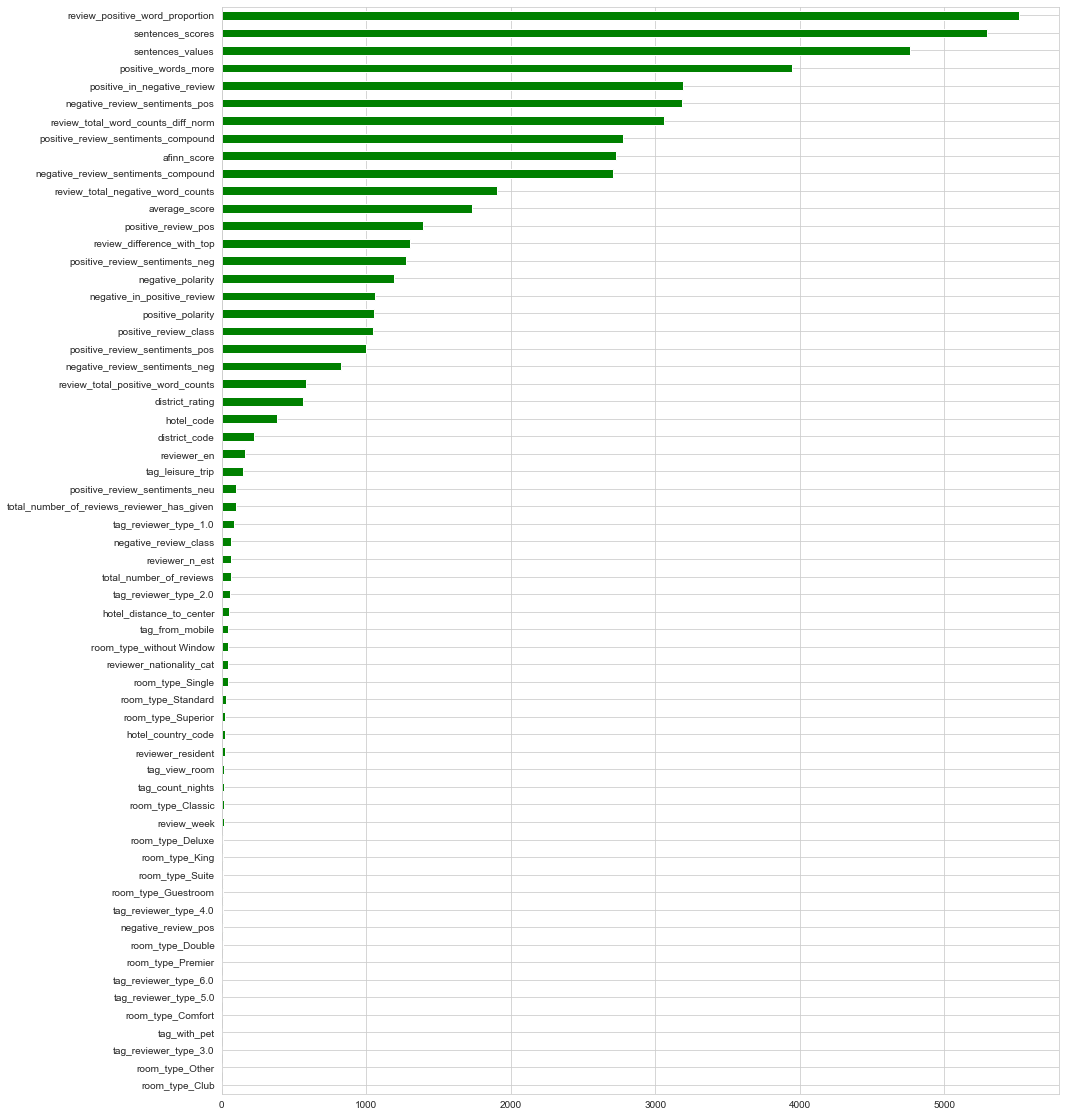

In [98]:
imp_num = pd.Series(f_classif(X_df[X_df.columns], y)[0], index = X_df.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

Удалим признаки, не демонстрирующие никакой корреляции с целевым. Это признаки некоторых типов номеров и типов путешественника, а также признак путешественников с животными.

Хотя у меня была гипотеза, что может быть их оценки в целом выше, так как не многие отели пускают постояльцев с домашними питомцами, и возможно, благодарные хозяева оставляют позитивные отзывы. Но нет...)

In [99]:
drop_columns = ['room_type_Other', 'room_type_Club', 'room_type_Comfort', 'room_type_Double', 'room_type_Premier',
               'room_type_Guestroom', 'room_type_King', 'room_type_Suite', 'room_type_Deluxe', 'tag_with_pet',
                'tag_reviewer_type_3.0', 'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0']

In [100]:
# удалим незначимые числовые данные:
print(f'Удалим еще {len(drop_columns)} столбцов с числовыми данными.')
X_df = X_df.drop(drop_columns, axis = 1)

print(f'Итоговое получившееся количество признаков: {len(X_df.columns)}.')

Удалим еще 14 столбцов с числовыми данными.
Итоговое получившееся количество признаков: 48.


# 3. Обучение модели и получение предсказания:

### Разбиваем датафрейм на части, необходимые для обучения и тестирования модели:

In [101]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.25, random_state=42)

### Создаем модель и получаем предсказание:

In [102]:
%%time

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

CPU times: user 9min 1s, sys: 3.04 s, total: 9min 4s
Wall time: 9min 10s


### Оценим итоговые метрики:

In [103]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 3))

MAPE: 11.596


### Оценим вклад важнейших признаков в построение модели:

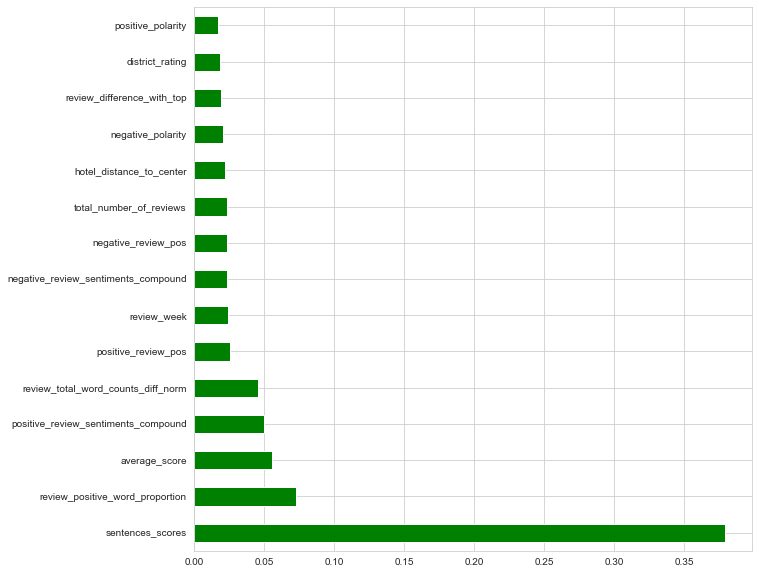

In [104]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X_df.columns)
feat_importances.sort_values(inplace=True)
feat_importances.nlargest(15).plot(kind='barh', color='green');

#### ***Среди 15 главных в построения модели признаков с итоговым MAPE 11.6 - только два исходных - рейтинг отеля и общее количество отзывов об отеле (несправедливо недооцененный мной признак). Остальные - это признаки сконструированные в процессе исследования данных. Учитывая, что критерий MAPE на необработанных данных - 14.14%, только при помощи инструментов EDA мне удалось улучшить его примерно на 18 процентов***
***Несмотря на то, что появился такой мощный инструмент, как анализ тональности с библиотекой Flair, среди 15 важнейших признаков есть и дистанция до центра и соотношение количества слов в разных частях отзыва. Но конечно, главную роль сыграли признаки, отвечающие за определение эмоциональной окраски текста.***